In [1]:
%load_ext autoreload
%autoreload 2

import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

# Artisinal, small-batch, handmade modules
import classification_metrics

## Def describe

In [2]:
def describe(df, random=False):
    print(df.shape)
    print("--- First 5 entries ---")
    display(df.head())
    if random:
        print('--- Random subset ---')
        display(df.sample(5))

## Shared cell types

In [3]:
SHARED_CELLTYPES = [
    "Capillary",
    "Alveolar Epithelial Type 2",
    "B cell",
    "T cell",
    "Natural Killer T cell",
    "Macrophage",
    "Monocyte",
    "Dendritic",
    "Fibroblast",
    "Smooth Muscle and Myofibroblast",
]

## Broad to compartment

In [4]:
BROAD_TO_COMPARTMENT = pd.Series({
    "Capillary": "endothelial",
    "Artery": "endothelial",
    "Vein": "endothelial",
    "Alveolar Epithelial Type 2": "epithelial",
    "T cell": "lymphoid",
    "B cell": "lymphoid",
    "Natural Killer T cell": "lymphoid",
    "Natural Killer": "lymphoid",
    "Monocyte": "myeloid",
    "Macrophage": "myeloid",
    "Dendritic": "myeloid",
    "Neutrophil": "myeloid",
    "Fibroblast": "stromal",
    "Smooth Muscle and Myofibroblast": "stromal",
})
broad_to_compartment = BROAD_TO_COMPARTMENT[SHARED_CELLTYPES]
broad_to_compartment

Capillary                          endothelial
Alveolar Epithelial Type 2          epithelial
B cell                                lymphoid
T cell                                lymphoid
Natural Killer T cell                 lymphoid
Macrophage                             myeloid
Monocyte                               myeloid
Dendritic                              myeloid
Fibroblast                             stromal
Smooth Muscle and Myofibroblast        stromal
dtype: object

## file paths

In [5]:
sig_outdir_base = "/home/olga/data_sm/immune-evolution/kmer-signatures"

top_hit_suffix = os.path.join(
    "4--aggregated-results",
    "sourmash-search-results--top-hit.parquet",
)

self2self_parquet = os.path.join(
    sig_outdir_base, "0--mouse2mouse", "0--self2self-bootstrapped", top_hit_suffix
)

mouse2mouse_parquet = os.path.join(
    sig_outdir_base, "0--mouse2mouse", "1--mouse2mouse", top_hit_suffix
)

lemur_parquet = os.path.join(sig_outdir_base, "4--test-lemur", top_hit_suffix)

bat_parquet = os.path.join(sig_outdir_base, "3--test-bat", top_hit_suffix)
human_parquet = os.path.join(sig_outdir_base, "2--test-human", top_hit_suffix)

top_hit_paths = {
#     "self": self2self_parquet,
    "mouse": mouse2mouse_parquet,
    "lemur": lemur_parquet,
    "bat": bat_parquet,
    "human": human_parquet,
}

# Read in classification data

In [6]:
dfs = []
for species, parquet in top_hit_paths.items():
    try:
        df = pd.read_parquet(parquet)
    except FileNotFoundError:
        print(f"Could not find parquet for {species}")
        continue
    
    print(f'Species: {species}')
    describe(df)

    df["comparison"] = species
    df = df.query(
        "groundtruth_celltype in @SHARED_CELLTYPES "
        "and predicted_celltype in @SHARED_CELLTYPES"
    )
    df.index.name = 'query_cell_id'
    dfs.append(df)
predicted_cells = pd.concat(dfs, ignore_index=False)

databases_to_choose = 'min-10-percent-shared-kmers-remove-common-kmers', 'min-5-percent-shared-kmers-remove-common-kmers'

# Only use database with common k-mers removed because without that, no AT2 cells are predicted!
# predicted_cells = predicted_cells.query('database_type == "remove_common"')
predicted_cells = predicted_cells.loc[predicted_cells.database_type.isin(databases_to_choose)]
predicted_cells.groundtruth_celltype = predicted_cells.groundtruth_celltype.cat.remove_unused_categories()
# predicted_cells.predicted_celltype = predicted_cells.predicted_celltype.cat.remove_unused_categories()
describe(predicted_cells)

Species: mouse
(65940, 24)
--- First 5 entries ---


,similarity,mouse1_broad_group,search_method,database_type,sketch_id,mol_or_alpha,alphabet,ksize,sketch_style,sketch_value,...,mouse2_compartment_group,database_method,mouse2_human_readable,broad_group_matches,broad_group_matches_string,alpha_ksize,alpha_match,mouse2_match,groundtruth_celltype,predicted_celltype
mouse2_cell_id,,,,,,,,,,,,,,,,,,,,,
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA,0.296154,Monocyte,containment,min-10-percent-shared-kmers,alphabet-DNA__ksize-21__scaled-10,alphabet,DNA,21,scaled,10,...,lymphoid,min-10-percent-shared-kmers: containment,male:female,False,different celltype,"DNA, k:21","DNA, different celltype","male:female, different celltype",T cell,Monocyte
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA,0.271510,Monocyte,containment,min-10-percent-shared-kmers,alphabet-dayhoff__ksize-51__scaled-10,alphabet,dayhoff,51,scaled,10,...,lymphoid,min-10-percent-shared-kmers: containment,male:female,False,different celltype,"dayhoff, k:51","dayhoff, different celltype","male:female, different celltype",T cell,Monocyte
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA,0.296568,Monocyte,containment,min-10-percent-shared-kmers,alphabet-protein__ksize-30__scaled-10,alphabet,protein,30,scaled,10,...,lymphoid,min-10-percent-shared-kmers: containment,male:female,False,different celltype,"protein, k:30","protein, different celltype","male:female, different celltype",T cell,Monocyte
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA,0.507136,T cell,similarity_abundance,min-10-percent-shared-kmers,alphabet-DNA__ksize-21__scaled-10,alphabet,DNA,21,scaled,10,...,lymphoid,min-10-percent-shared-kmers: similarity_abundance,male:female,True,same celltype,"DNA, k:21","DNA, same celltype","male:female, same celltype",T cell,T cell
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA,0.537653,T cell,similarity_abundance,min-10-percent-shared-kmers,alphabet-dayhoff__ksize-51__scaled-10,alphabet,dayhoff,51,scaled,10,...,lymphoid,min-10-percent-shared-kmers: similarity_abundance,male:female,True,same celltype,"dayhoff, k:51","dayhoff, same celltype","male:female, same celltype",T cell,T cell


Species: lemur
(100652, 17)
--- First 5 entries ---


,similarity,mouse_broad_group,search_method,sketch_id,mol_or_alpha,alphabet,ksize,sketch_style,sketch_value,lemur_channel,lemur_cell_ontology_class,lemur_narrow_group,lemur_broad_group,lemur_compartment_group,database_type,groundtruth_celltype,predicted_celltype
lemur_cell_id,,,,,,,,,,,,,,,,,
ANTOINE_LUNG_CD31__AAACCTGAGAAACGAG,0.114944,Dendritic,containment,alphabet-dayhoff__ksize-51__scaled-10,alphabet,dayhoff,51,scaled,10,ANTOINE_LUNG_CD31,macrophage,Macrophage,Macrophage,myeloid,min-10-percent-shared-kmers,Macrophage,Dendritic
ANTOINE_LUNG_CD31__AAACCTGAGAAACGAG,0.110182,Dendritic,containment,alphabet-protein__ksize-30__scaled-10,alphabet,protein,30,scaled,10,ANTOINE_LUNG_CD31,macrophage,Macrophage,Macrophage,myeloid,min-10-percent-shared-kmers,Macrophage,Dendritic
ANTOINE_LUNG_CD31__AAACCTGAGAAACGAG,0.090060,Macrophage,similarity_abundance,alphabet-dayhoff__ksize-51__scaled-10,alphabet,dayhoff,51,scaled,10,ANTOINE_LUNG_CD31,macrophage,Macrophage,Macrophage,myeloid,min-10-percent-shared-kmers,Macrophage,Macrophage
ANTOINE_LUNG_CD31__AAACCTGAGAAACGAG,0.013232,Macrophage,similarity_abundance,alphabet-protein__ksize-30__scaled-10,alphabet,protein,30,scaled,10,ANTOINE_LUNG_CD31,macrophage,Macrophage,Macrophage,myeloid,min-10-percent-shared-kmers,Macrophage,Macrophage
ANTOINE_LUNG_CD31__AAACCTGAGAAACGAG,0.044129,Dendritic,containment,alphabet-dayhoff__ksize-51__scaled-10,alphabet,dayhoff,51,scaled,10,ANTOINE_LUNG_CD31,macrophage,Macrophage,Macrophage,myeloid,min-10-percent-shared-kmers-remove-common-kmers,Macrophage,Dendritic


Species: bat
(216998, 17)
--- First 5 entries ---


,similarity,mouse_broad_group,search_method,sketch_id,mol_or_alpha,alphabet,ksize,sketch_style,sketch_value,bat_channel,bat_cell_ontology_class,bat_narrow_group,bat_broad_group,bat_compartment_group,database_type,groundtruth_celltype,predicted_celltype
bat_cell_id,,,,,,,,,,,,,,,,,
bat2-LU__AAACCTGAGGTACTCT,0.021308,Dendritic,containment,alphabet-DNA__ksize-21__scaled-10,alphabet,DNA,21,scaled,10,bat2-LU,nan,Macrophage,Macrophage,myeloid,min-10-percent-shared-kmers,Macrophage,Dendritic
bat2-LU__AAACCTGAGGTACTCT,0.056749,Dendritic,containment,alphabet-dayhoff__ksize-51__scaled-10,alphabet,dayhoff,51,scaled,10,bat2-LU,nan,Macrophage,Macrophage,myeloid,min-10-percent-shared-kmers,Macrophage,Dendritic
bat2-LU__AAACCTGAGGTACTCT,0.064116,Dendritic,containment,alphabet-protein__ksize-30__scaled-10,alphabet,protein,30,scaled,10,bat2-LU,nan,Macrophage,Macrophage,myeloid,min-10-percent-shared-kmers,Macrophage,Dendritic
bat2-LU__AAACCTGAGGTACTCT,0.060978,Macrophage,similarity_abundance,alphabet-DNA__ksize-21__scaled-10,alphabet,DNA,21,scaled,10,bat2-LU,nan,Macrophage,Macrophage,myeloid,min-10-percent-shared-kmers,Macrophage,Macrophage
bat2-LU__AAACCTGAGGTACTCT,0.030150,Dendritic,similarity_abundance,alphabet-dayhoff__ksize-51__scaled-10,alphabet,dayhoff,51,scaled,10,bat2-LU,nan,Macrophage,Macrophage,myeloid,min-10-percent-shared-kmers,Macrophage,Dendritic


Species: human
(424610, 17)
--- First 5 entries ---


,similarity,mouse_broad_group,search_method,sketch_id,mol_or_alpha,alphabet,ksize,sketch_style,sketch_value,human_channel,human_cell_ontology_class,human_narrow_group,human_broad_group,human_compartment_group,database_type,groundtruth_celltype,predicted_celltype
human_cell_id,,,,,,,,,,,,,,,,,
P3_2__AAACCTGGTTAGAACA,0.047525,Dendritic,containment,alphabet-DNA__ksize-21__scaled-10,alphabet,DNA,21,scaled,10,P3_2,macrophage,Macrophage,Macrophage,myeloid,min-10-percent-shared-kmers,Macrophage,Dendritic
P3_2__AAACCTGGTTAGAACA,0.246955,Dendritic,containment,alphabet-dayhoff__ksize-51__scaled-10,alphabet,dayhoff,51,scaled,10,P3_2,macrophage,Macrophage,Macrophage,myeloid,min-10-percent-shared-kmers,Macrophage,Dendritic
P3_2__AAACCTGGTTAGAACA,0.231591,Dendritic,containment,alphabet-protein__ksize-30__scaled-10,alphabet,protein,30,scaled,10,P3_2,macrophage,Macrophage,Macrophage,myeloid,min-10-percent-shared-kmers,Macrophage,Dendritic
P3_2__AAACCTGGTTAGAACA,0.016143,Dendritic,containment,alphabet-DNA__ksize-21__scaled-10,alphabet,DNA,21,scaled,10,P3_2,macrophage,Macrophage,Macrophage,myeloid,min-10-percent-shared-kmers-remove-common-kmers,Macrophage,Dendritic
P3_2__AAACCTGGTTAGAACA,0.102805,Dendritic,containment,alphabet-dayhoff__ksize-51__scaled-10,alphabet,dayhoff,51,scaled,10,P3_2,macrophage,Macrophage,Macrophage,myeloid,min-10-percent-shared-kmers-remove-common-kmers,Macrophage,Dendritic


(329784, 41)
--- First 5 entries ---


,similarity,mouse1_broad_group,search_method,database_type,sketch_id,mol_or_alpha,alphabet,ksize,sketch_style,sketch_value,...,bat_channel,bat_cell_ontology_class,bat_narrow_group,bat_broad_group,bat_compartment_group,human_channel,human_cell_ontology_class,human_narrow_group,human_broad_group,human_compartment_group
query_cell_id,,,,,,,,,,,,,,,,,,,,,
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA,0.182216,Monocyte,containment,min-10-percent-shared-kmers-remove-common-kmers,alphabet-DNA__ksize-21__scaled-10,alphabet,DNA,21,scaled,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA,0.165634,Monocyte,containment,min-10-percent-shared-kmers-remove-common-kmers,alphabet-dayhoff__ksize-51__scaled-10,alphabet,dayhoff,51,scaled,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA,0.171718,Monocyte,containment,min-10-percent-shared-kmers-remove-common-kmers,alphabet-protein__ksize-30__scaled-10,alphabet,protein,30,scaled,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA,0.083241,T cell,similarity_abundance,min-10-percent-shared-kmers-remove-common-kmers,alphabet-DNA__ksize-21__scaled-10,alphabet,DNA,21,scaled,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA,0.118770,T cell,similarity_abundance,min-10-percent-shared-kmers-remove-common-kmers,alphabet-dayhoff__ksize-51__scaled-10,alphabet,dayhoff,51,scaled,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Add `database_method` column for containment vs similarity

In [7]:
predicted_cells['database_method'] = predicted_cells.database_type.astype(str) + ': ' + predicted_cells.search_method.astype(str)

In [8]:
predicted_cells.database_type.value_counts()

min-5-percent-shared-kmers-remove-common-kmers     164892
min-10-percent-shared-kmers-remove-common-kmers    164892
Name: database_type, dtype: int64

In [9]:
predicted_cells.groupby(['comparison', 'database_method']).size()

comparison  database_method                                                      
bat         min-10-percent-shared-kmers-remove-common-kmers: containment             23255
            min-10-percent-shared-kmers-remove-common-kmers: similarity_abundance    23255
            min-5-percent-shared-kmers-remove-common-kmers: containment              23255
            min-5-percent-shared-kmers-remove-common-kmers: similarity_abundance     23255
human       min-10-percent-shared-kmers-remove-common-kmers: containment             42461
            min-10-percent-shared-kmers-remove-common-kmers: similarity_abundance    42461
            min-5-percent-shared-kmers-remove-common-kmers: containment              42461
            min-5-percent-shared-kmers-remove-common-kmers: similarity_abundance     42461
lemur       min-10-percent-shared-kmers-remove-common-kmers: containment             10136
            min-10-percent-shared-kmers-remove-common-kmers: similarity_abundance    10136
        

In [10]:
predicted_cells.groupby(['comparison', 'database_method', 'sketch_id']).size()

comparison  database_method                                                        sketch_id                            
bat         min-10-percent-shared-kmers-remove-common-kmers: containment           alphabet-DNA__ksize-21__scaled-10         7776
                                                                                   alphabet-dayhoff__ksize-51__scaled-10     7703
                                                                                   alphabet-protein__ksize-30__scaled-10     7776
            min-10-percent-shared-kmers-remove-common-kmers: similarity_abundance  alphabet-DNA__ksize-21__scaled-10         7776
                                                                                   alphabet-dayhoff__ksize-51__scaled-10     7703
                                                                                   alphabet-protein__ksize-30__scaled-10     7776
            min-5-percent-shared-kmers-remove-common-kmers: containment            alphabet-DNA__ks

## Only use `min-XX-percent-shared-kmers-remove-common-kmers` data

In [11]:
predicted_cells = predicted_cells.loc[
    predicted_cells.database_type.str.contains(
        "percent-shared-kmers-remove-common-kmers"
    )
]
describe(predicted_cells)

(329784, 41)
--- First 5 entries ---


,similarity,mouse1_broad_group,search_method,database_type,sketch_id,mol_or_alpha,alphabet,ksize,sketch_style,sketch_value,...,bat_channel,bat_cell_ontology_class,bat_narrow_group,bat_broad_group,bat_compartment_group,human_channel,human_cell_ontology_class,human_narrow_group,human_broad_group,human_compartment_group
query_cell_id,,,,,,,,,,,,,,,,,,,,,
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA,0.182216,Monocyte,containment,min-10-percent-shared-kmers-remove-common-kmers,alphabet-DNA__ksize-21__scaled-10,alphabet,DNA,21,scaled,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA,0.165634,Monocyte,containment,min-10-percent-shared-kmers-remove-common-kmers,alphabet-dayhoff__ksize-51__scaled-10,alphabet,dayhoff,51,scaled,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA,0.171718,Monocyte,containment,min-10-percent-shared-kmers-remove-common-kmers,alphabet-protein__ksize-30__scaled-10,alphabet,protein,30,scaled,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA,0.083241,T cell,similarity_abundance,min-10-percent-shared-kmers-remove-common-kmers,alphabet-DNA__ksize-21__scaled-10,alphabet,DNA,21,scaled,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA,0.118770,T cell,similarity_abundance,min-10-percent-shared-kmers-remove-common-kmers,alphabet-dayhoff__ksize-51__scaled-10,alphabet,dayhoff,51,scaled,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Containment doesn't perform well because it doesn't take abundance into account -- Only use similarity with abundance

In [12]:
predicted_cells = predicted_cells.query('search_method == "similarity_abundance"')
describe(predicted_cells)

(164892, 41)
--- First 5 entries ---


,similarity,mouse1_broad_group,search_method,database_type,sketch_id,mol_or_alpha,alphabet,ksize,sketch_style,sketch_value,...,bat_channel,bat_cell_ontology_class,bat_narrow_group,bat_broad_group,bat_compartment_group,human_channel,human_cell_ontology_class,human_narrow_group,human_broad_group,human_compartment_group
query_cell_id,,,,,,,,,,,,,,,,,,,,,
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA,0.083241,T cell,similarity_abundance,min-10-percent-shared-kmers-remove-common-kmers,alphabet-DNA__ksize-21__scaled-10,alphabet,DNA,21,scaled,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA,0.118770,T cell,similarity_abundance,min-10-percent-shared-kmers-remove-common-kmers,alphabet-dayhoff__ksize-51__scaled-10,alphabet,dayhoff,51,scaled,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA,0.112218,T cell,similarity_abundance,min-10-percent-shared-kmers-remove-common-kmers,alphabet-protein__ksize-30__scaled-10,alphabet,protein,30,scaled,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA,0.086712,T cell,similarity_abundance,min-5-percent-shared-kmers-remove-common-kmers,alphabet-DNA__ksize-21__scaled-10,alphabet,DNA,21,scaled,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MACA_18m_F_LUNG_51__AAACCTGCAGCCTATA,0.119992,T cell,similarity_abundance,min-5-percent-shared-kmers-remove-common-kmers,alphabet-dayhoff__ksize-51__scaled-10,alphabet,dayhoff,51,scaled,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Add predicted comaprtment

In [13]:
predicted_cells["predicted_compartment"] = predicted_cells["predicted_celltype"].map(
    broad_to_compartment
)
predicted_cells["groundtruth_compartment"] = predicted_cells["groundtruth_celltype"].map(
    broad_to_compartment
)

# Broad group

## Booststrap and compute score

In [14]:
%%time

scoring_groupby = ['comparison', 'database_type', 'search_method', 'alphabet', 'ksize']
ground_truth_celltype_col = 'groundtruth_celltype'
predicted_celltype_col = 'predicted_celltype'

grouped = predicted_cells.groupby(scoring_groupby)

dfs = Parallel(n_jobs=96)(
    delayed(classification_metrics.subsample_and_score)(
        df,
        scoring_groupby=scoring_groupby,
        keys=keys,
        predicted_celltype_col=predicted_celltype_col,
        ground_truth_celltype_col=ground_truth_celltype_col,
        labels=SHARED_CELLTYPES,
    )
    for keys, df in tqdm(grouped, total=len(grouped))
)
broad_classification_metrics = pd.concat(
    dfs, ignore_index=True
)
describe(broad_classification_metrics)

100%|██████████| 24/24 [00:00<00:00, 87.19it/s]


(48000, 8)
--- First 5 entries ---


,comparison,database_type,search_method,alphabet,ksize,score_value,score_name,iteration
0,bat,min-10-percent-shared-kmers-remove-common-kmers,similarity_abundance,DNA,21,0.483092,f1_score,0
1,bat,min-10-percent-shared-kmers-remove-common-kmers,similarity_abundance,DNA,21,0.424779,adjusted_rand_score,0
2,bat,min-10-percent-shared-kmers-remove-common-kmers,similarity_abundance,DNA,21,0.551784,f1_score,1
3,bat,min-10-percent-shared-kmers-remove-common-kmers,similarity_abundance,DNA,21,0.408276,adjusted_rand_score,1
4,bat,min-10-percent-shared-kmers-remove-common-kmers,similarity_abundance,DNA,21,0.597917,f1_score,2


CPU times: user 1.37 s, sys: 2.37 s, total: 3.74 s
Wall time: 1min 9s


In [15]:
broad_classification_metrics["database_method"] = (
    broad_classification_metrics.database_type.astype(str)
    + ": "
    + broad_classification_metrics.search_method.astype(str)
)

In [16]:
broad_classification_metrics.comparison.value_counts()

mouse    12000
lemur    12000
human    12000
bat      12000
Name: comparison, dtype: int64

In [17]:
human_broad_classification_metrics = broad_classification_metrics.query(
#     '((comparison == "human") or (comparison == "mouse")) and'
    ' ((database_type == "min-10-percent-shared-kmers-remove-common-kmers") or (database_type == "min-5-percent-shared-kmers-remove-common-kmers"))'
)
describe(human_broad_classification_metrics)

(48000, 9)
--- First 5 entries ---


,comparison,database_type,search_method,alphabet,ksize,score_value,score_name,iteration,database_method
0,bat,min-10-percent-shared-kmers-remove-common-kmers,similarity_abundance,DNA,21,0.483092,f1_score,0,min-10-percent-shared-kmers-remove-common-kmer...
1,bat,min-10-percent-shared-kmers-remove-common-kmers,similarity_abundance,DNA,21,0.424779,adjusted_rand_score,0,min-10-percent-shared-kmers-remove-common-kmer...
2,bat,min-10-percent-shared-kmers-remove-common-kmers,similarity_abundance,DNA,21,0.551784,f1_score,1,min-10-percent-shared-kmers-remove-common-kmer...
3,bat,min-10-percent-shared-kmers-remove-common-kmers,similarity_abundance,DNA,21,0.408276,adjusted_rand_score,1,min-10-percent-shared-kmers-remove-common-kmer...
4,bat,min-10-percent-shared-kmers-remove-common-kmers,similarity_abundance,DNA,21,0.597917,f1_score,2,min-10-percent-shared-kmers-remove-common-kmer...


In [19]:
species_order = [
    "self",
    "mouse",
    "lemur",
    "human",
    "bat",
]
alphabet_order = "DNA", "protein", "dayhoff"

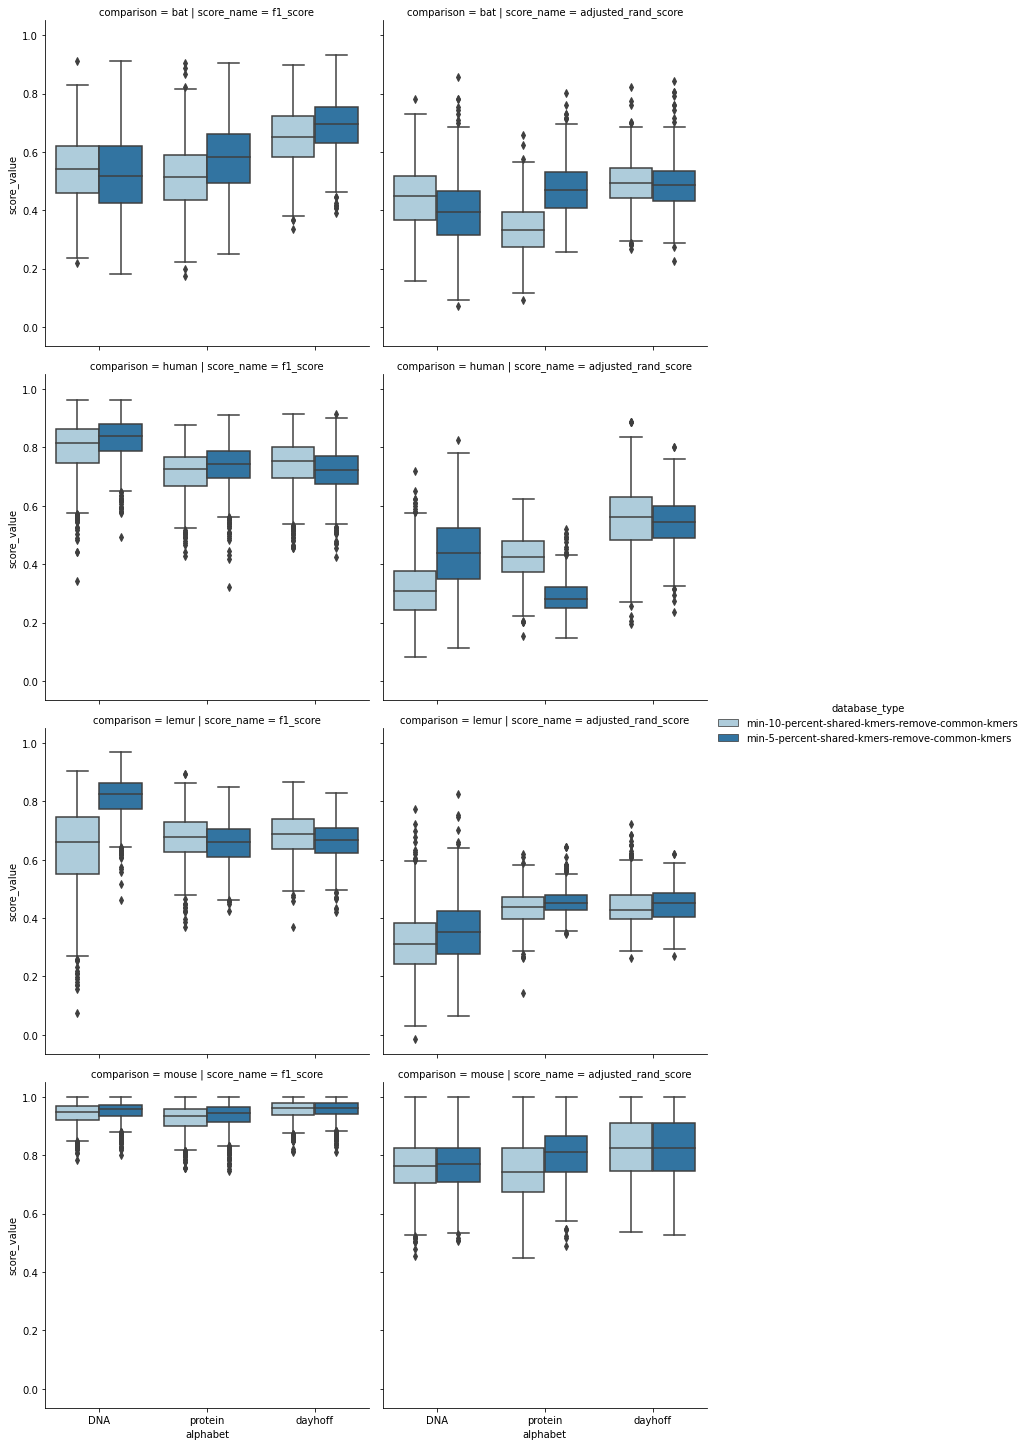

In [20]:
sns.catplot(
    
    data=human_broad_classification_metrics,
    x="alphabet",
    y="score_value",
    col="score_name",
    hue='database_type',
    row="comparison",
    kind='box',
    palette='Paired',
#     hue_order=species_order,
        order=alphabet_order
)

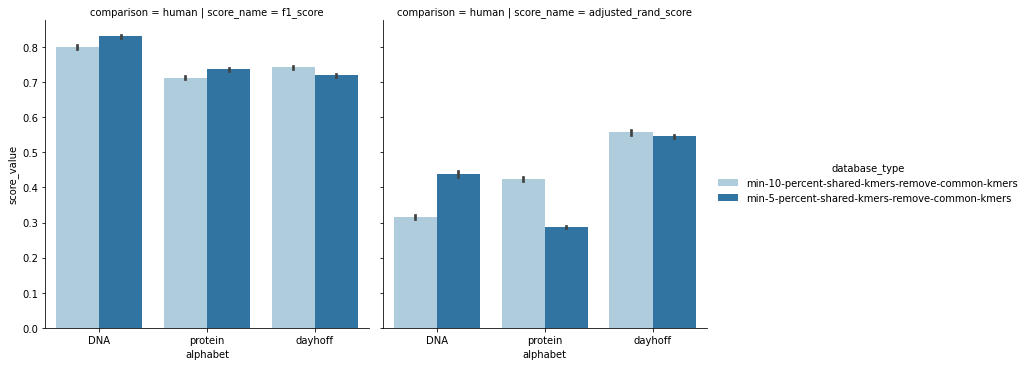

In [75]:
sns.catplot(
    
    data=human_broad_classification_metrics.query('comparison == "human"'),
    x="alphabet",
    y="score_value",
    col="score_name",
    hue='database_type',
    row="comparison",
    palette="Paired",
    kind='bar',
#     hue_order=species_order,
        order=alphabet_order
)

In [22]:
human_broad_classification_metrics.query(
    'alphabet == "dayhoff" and comparison == "human"'
).groupby(["alphabet", "score_name", "database_type", "comparison"]).score_value.mean()

alphabet  score_name           database_type                                    comparison
dayhoff   adjusted_rand_score  min-10-percent-shared-kmers-remove-common-kmers  human         0.556953
                               min-5-percent-shared-kmers-remove-common-kmers   human         0.545524
          f1_score             min-10-percent-shared-kmers-remove-common-kmers  human         0.742269
                               min-5-percent-shared-kmers-remove-common-kmers   human         0.719967
Name: score_value, dtype: float64

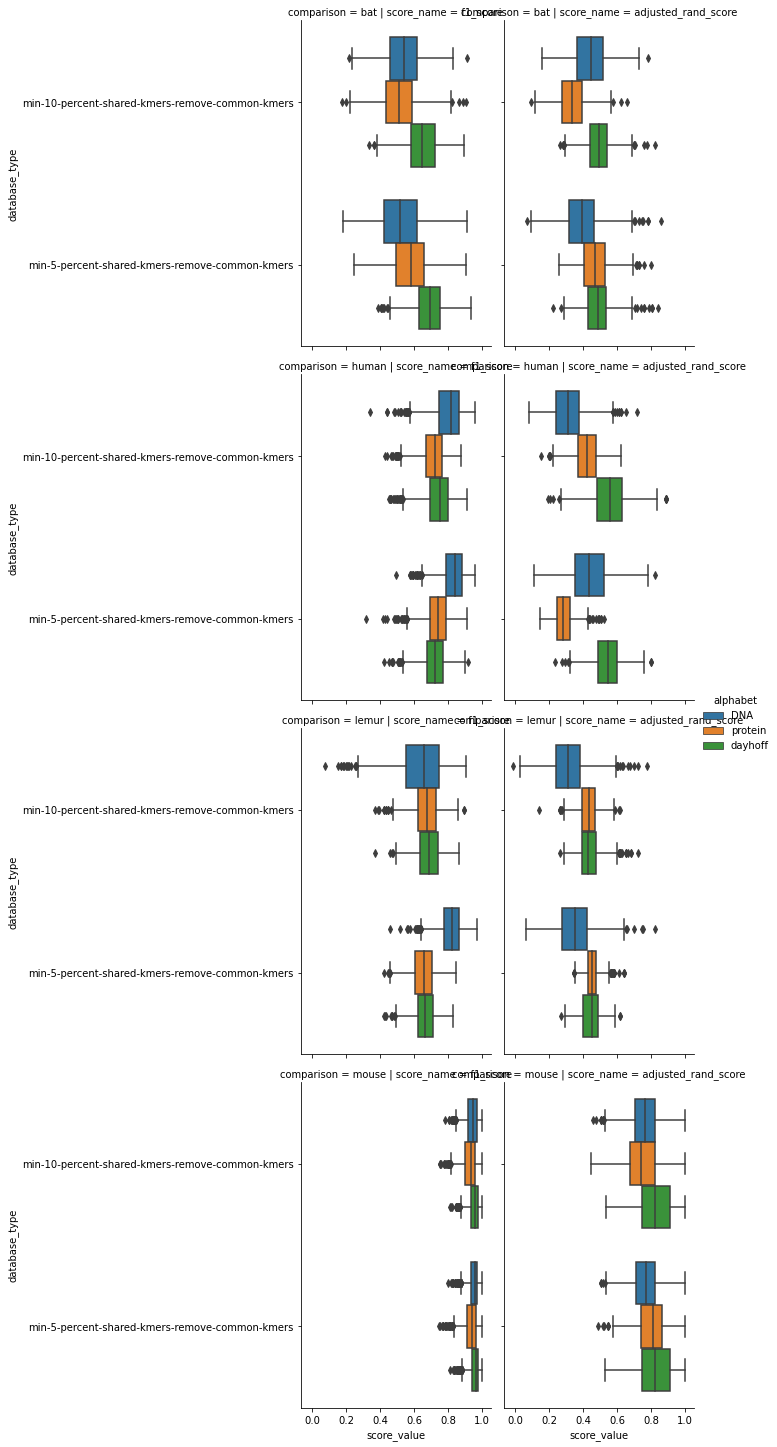

In [23]:
sns.catplot(
    
    data=human_broad_classification_metrics,
    hue="alphabet",
    x="score_value",
    col="score_name",
    y='database_type',
    row="comparison",
    kind='box',
        hue_order=alphabet_order
)

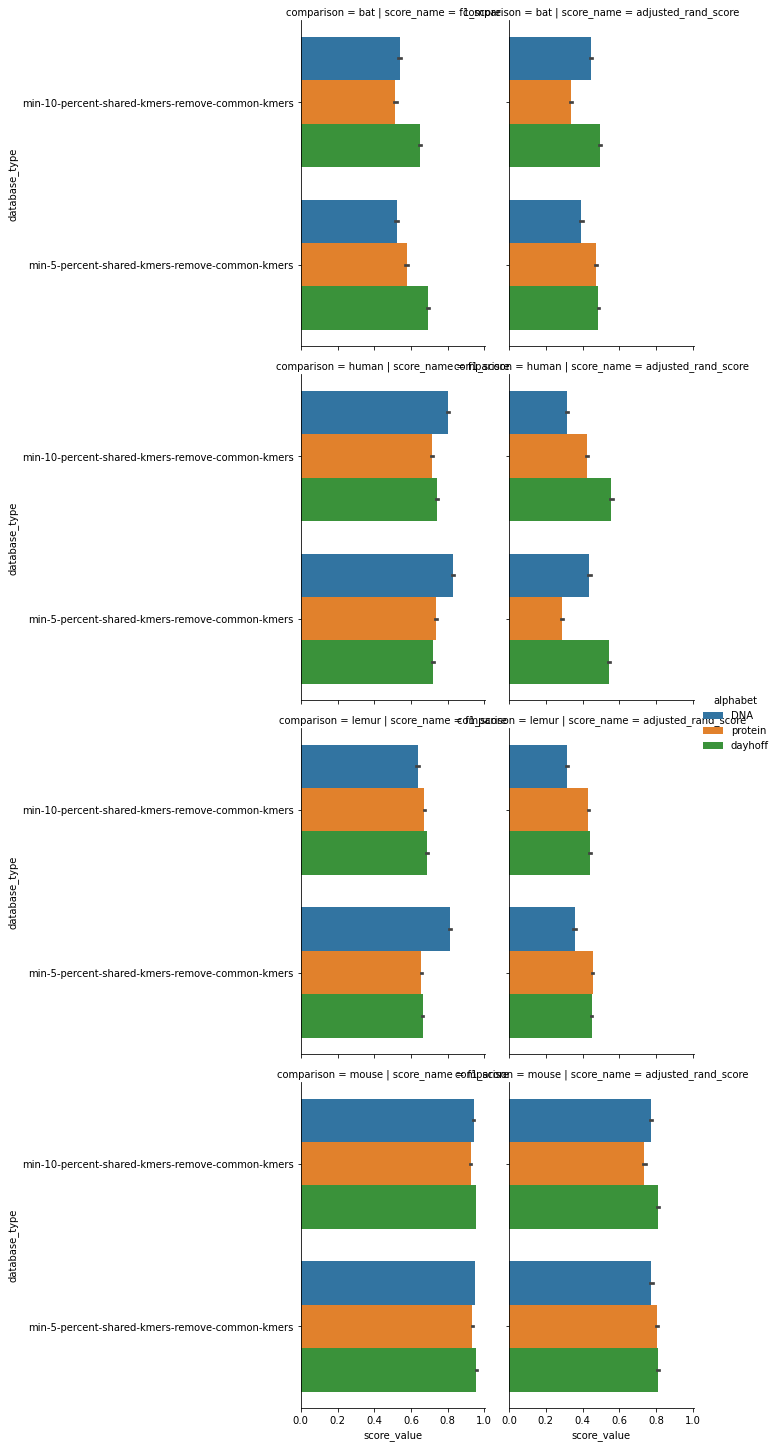

In [24]:
sns.catplot(
    
    data=human_broad_classification_metrics,
    hue="alphabet",
    x="score_value",
    col="score_name",
    y='database_type',
    row="comparison",
    kind='bar',
        hue_order=alphabet_order
)

In [25]:
broad_classification_metrics["alpha_ksize"] = broad_classification_metrics.apply(
    lambda x: "{alphabet}, k: {ksize}".format(**x), axis=1
)

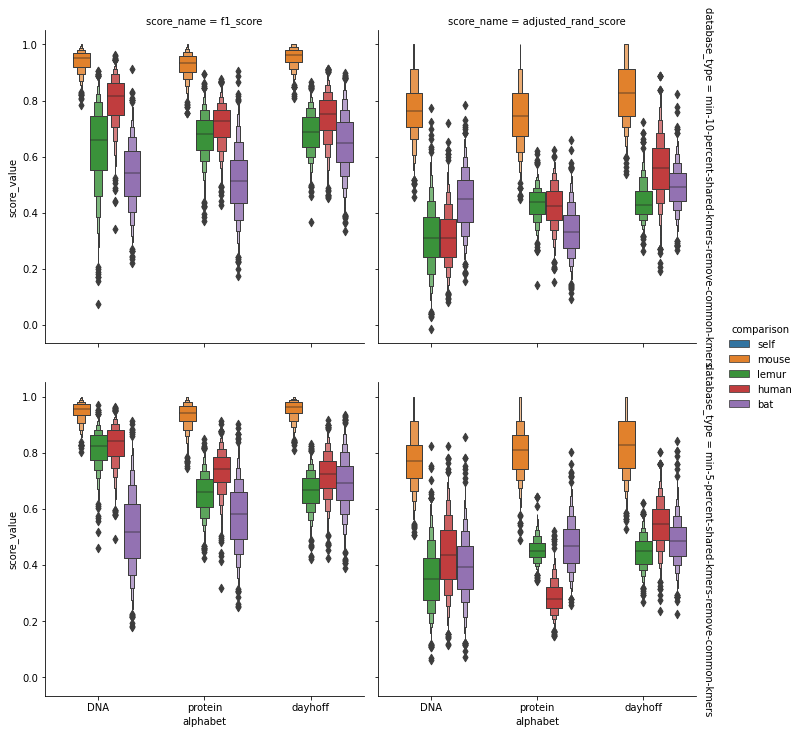

In [26]:
sns.catplot(
    
    data=broad_classification_metrics,
    x="alphabet",
    y="score_value",
    col="score_name",
    row='database_type',
    hue="comparison",
    kind='boxen',
    hue_order=species_order,
    order=alphabet_order,
    margin_titles=True
)

In [27]:
# sns.catplot(
    
#     data=subsampled_scores,
#     x="alphabet",
#     y="score_value",
#     col="score_name",
#     hue='database_type',
#     row="comparison",
#     kind='boxen',
# #     hue_order=hue_order,
#     order=alphabet_order,
#     palette='Paired',
#     row_order=species_order,
# )

## Compute Confusion matrices

In [28]:
databases_to_choose

('min-10-percent-shared-kmers-remove-common-kmers',
 'min-5-percent-shared-kmers-remove-common-kmers')

In [30]:
"""
The F1 score can be interpreted as a weighted average of the precision and recall, 
where an F1 score reaches its best value at 1 and worst score at 0
"""

"""
By definition a confusion matrix is such that is equal to the number of 
observations known to be in group and predicted to be in group
"""

top_hit_confusion_dfs = {}

for keys, df in predicted_cells.query("database_type in @databases_to_choose").groupby(
    scoring_groupby
):

    ground_truth = df[ground_truth_celltype_col]
    predicted = df[predicted_celltype_col]
    weight = df["similarity"]
    labels = sorted(list(set(ground_truth) | set(predicted)))

    cm = confusion_matrix(
        ground_truth,
        predicted,
        #         labels=labels,
        #         sample_weight=weight
    )
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    cm_df.index.name = "ground_truth"
    cm_df.columns.name = "predicted"
    cm_df = cm_df.reindex(index=SHARED_CELLTYPES, columns=SHARED_CELLTYPES)
    #     cm_df = cm_df.loc[SHARED_CELLTYPES, SHARED_CELLTYPES]
    top_hit_confusion_dfs[keys] = cm_df

### @paper Separately plot confusion matrices to fine tune parameters

In [31]:
# broad_to_compartment = one2one.obs.set_index('broad_group')['compartment_group']
# broad_to_compartment = broad_to_compartment.loc[~broad_to_compartment.index.duplicated()]
# broad_to_compartment.head()

In [32]:
# broad_to_compartment = broad_to_compartment.sort_values()
# broad_to_compartment

#### Assign figure folder

In [33]:
figure_folder = (
    "/home/olga/googledrive/ImmuneEvolution/figures/kmermaid_classification_metrics"
)
broad_confusion_matrix_folder = os.path.join(
    figure_folder, "confusion_matrices", "broad_group"
)
! mkdir -p $broad_confusion_matrix_folder

/home/olga/miniconda3/envs/immune-evolution/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


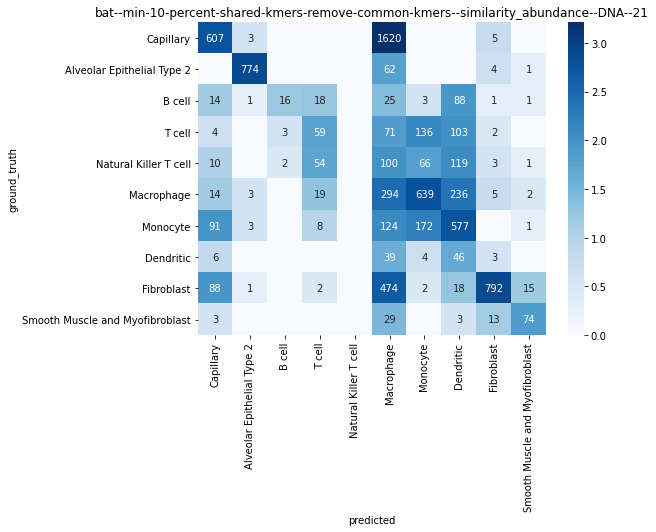

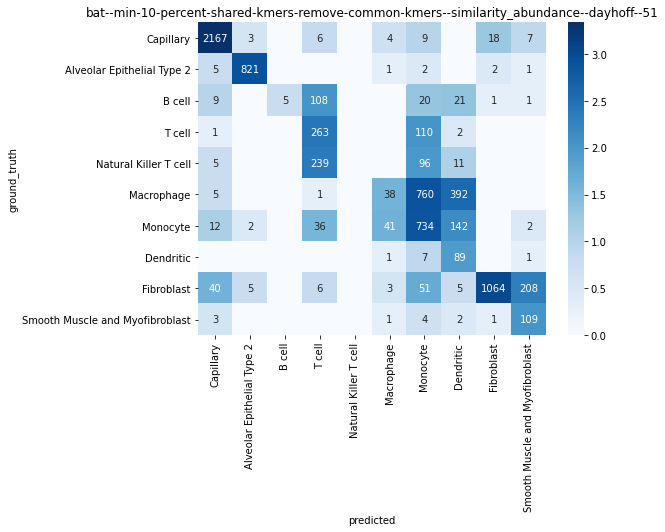

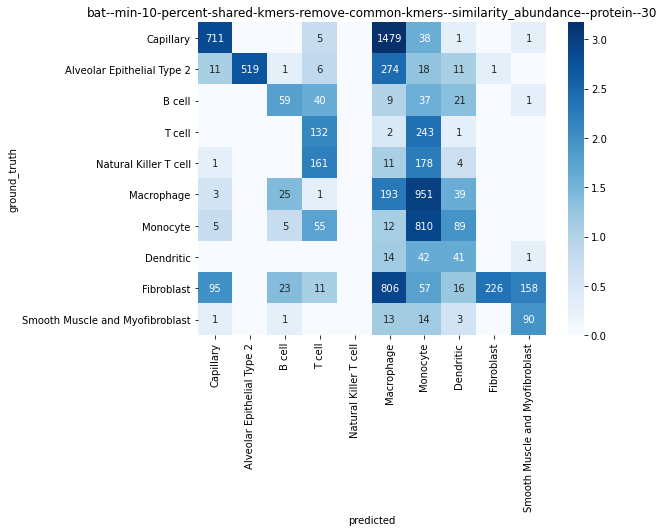

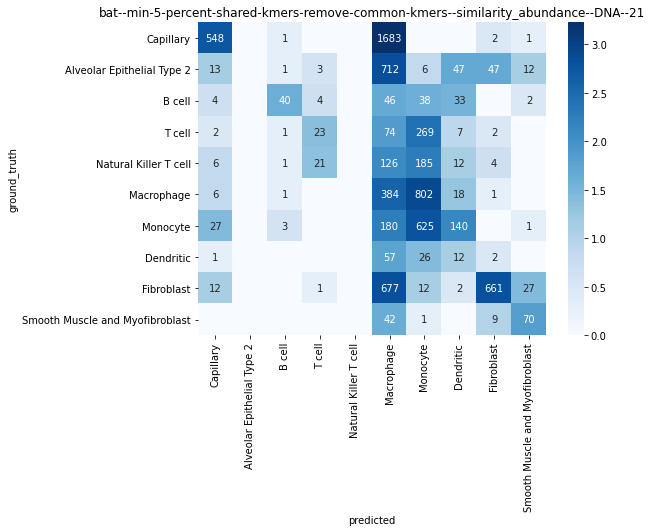

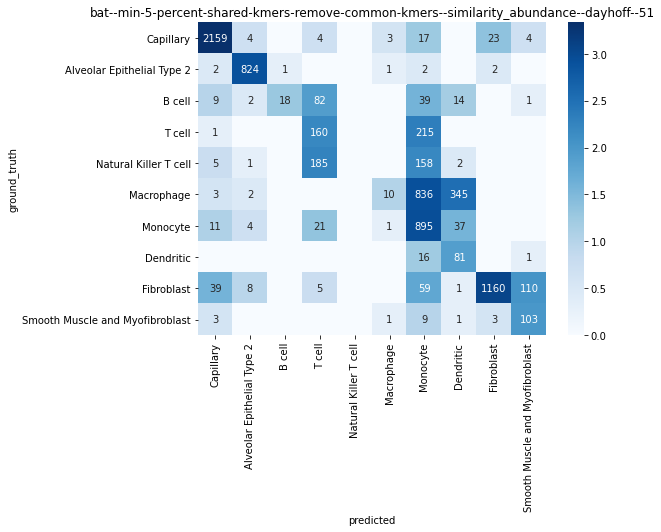

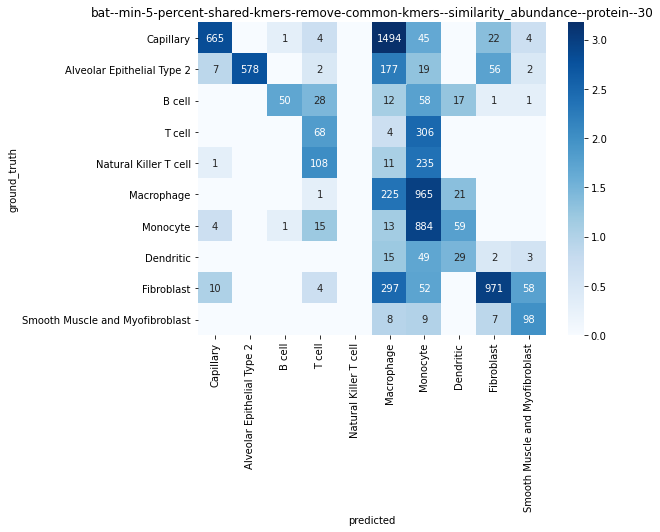

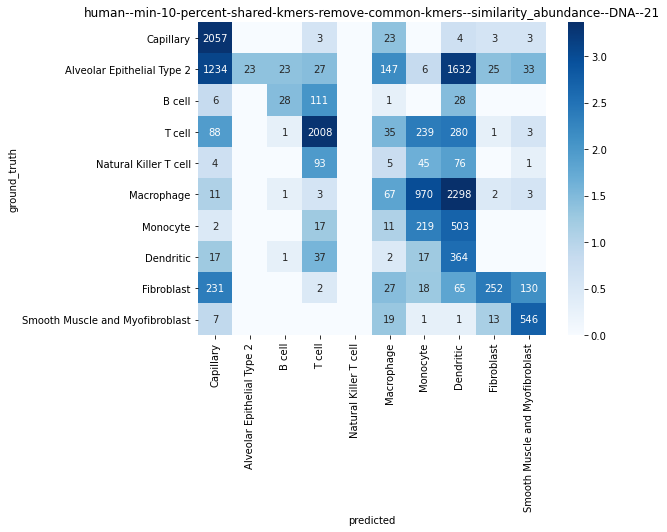

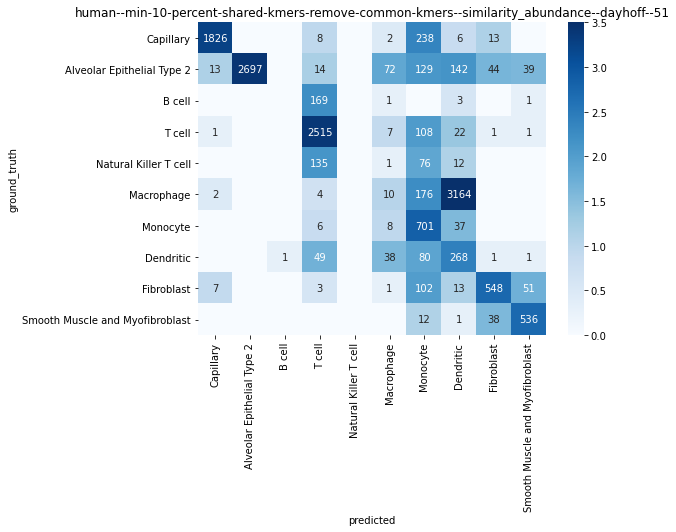

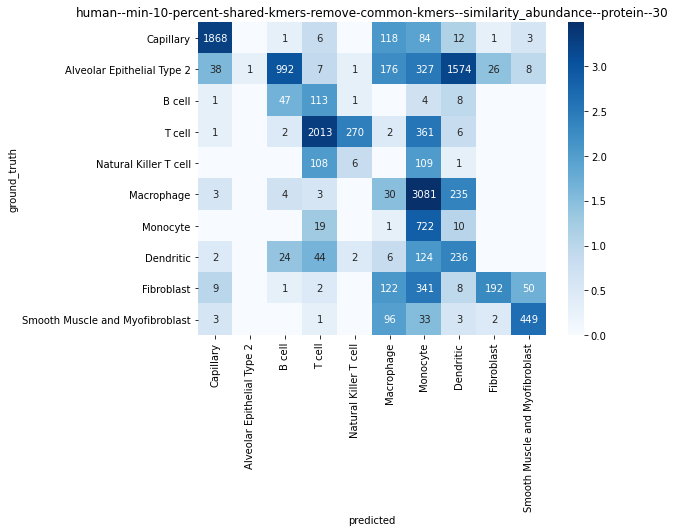

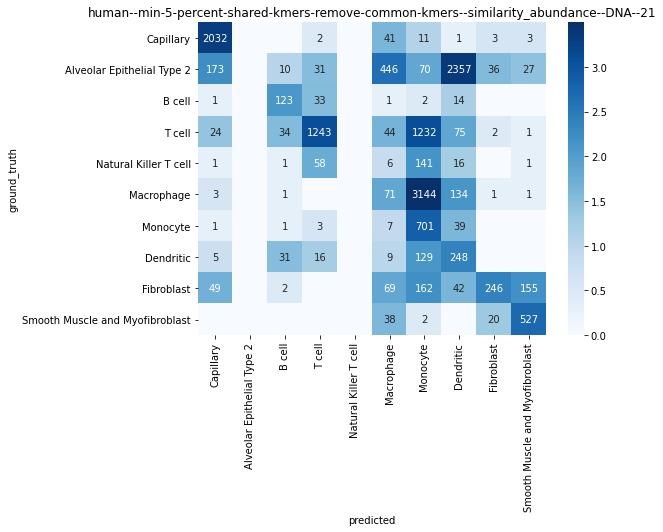

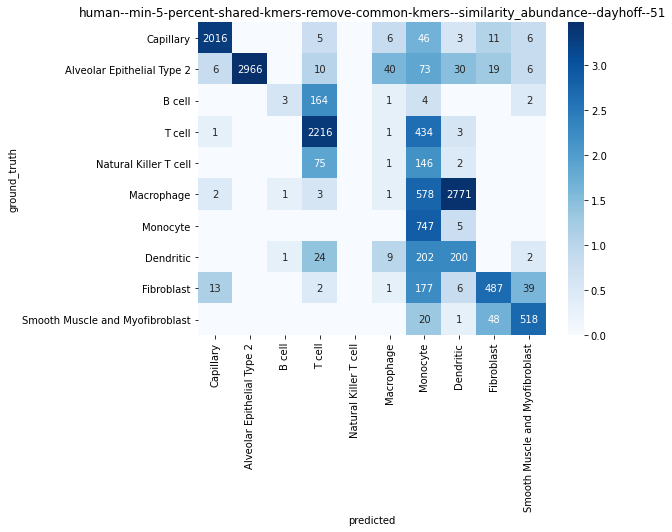

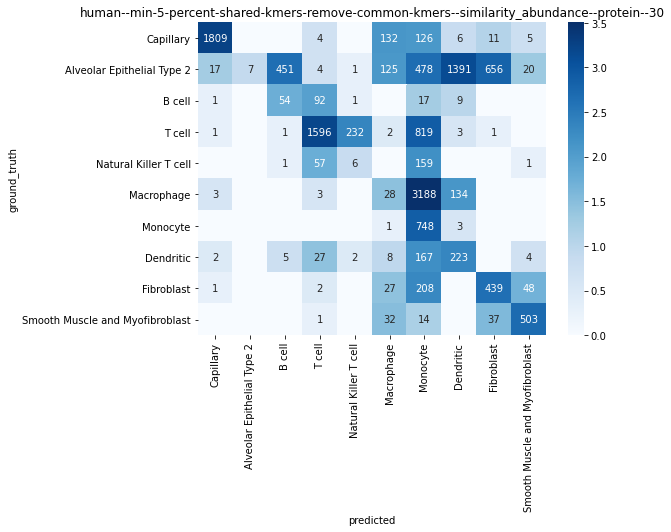

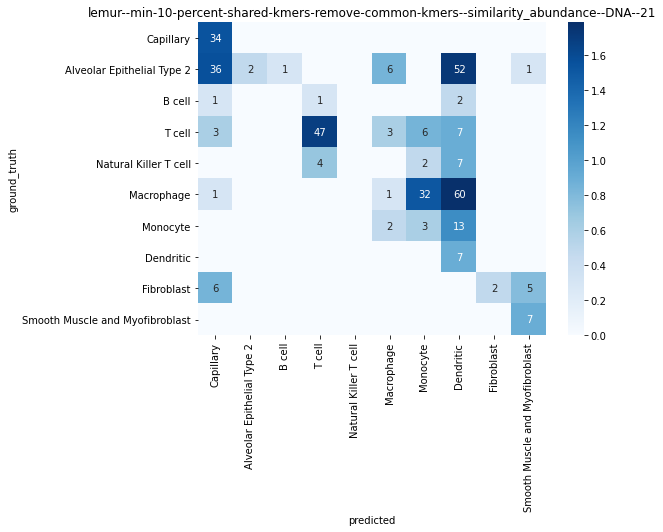

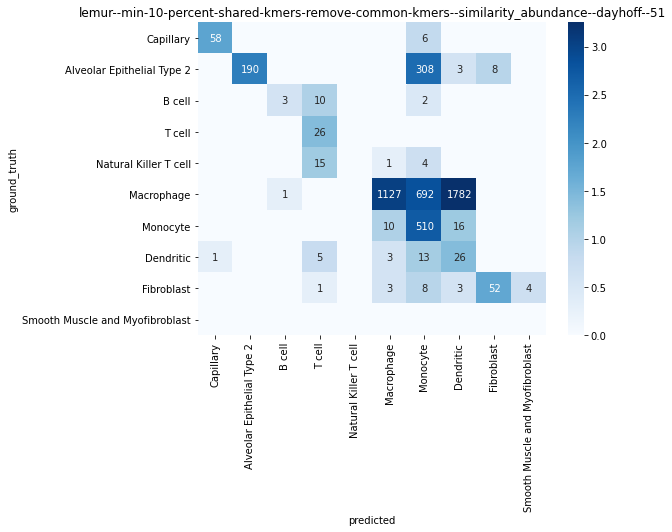

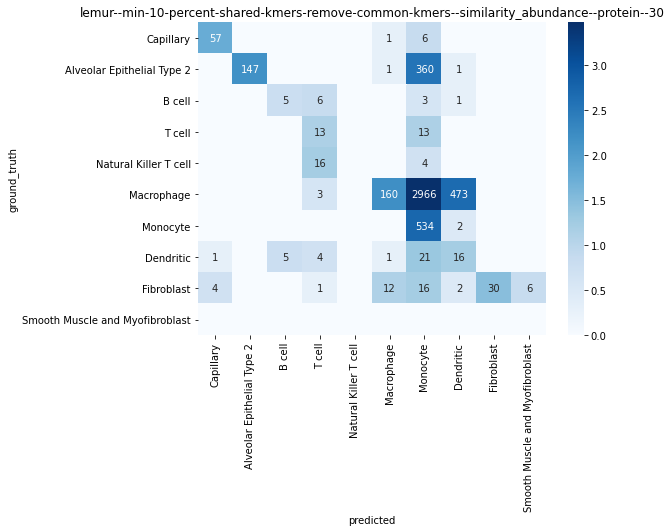

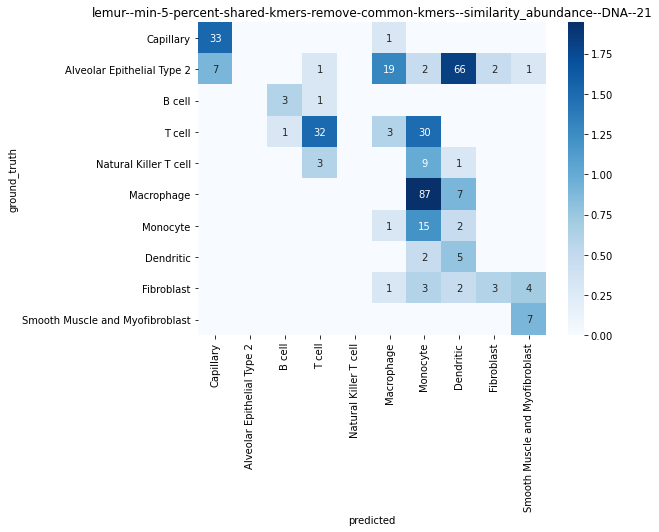

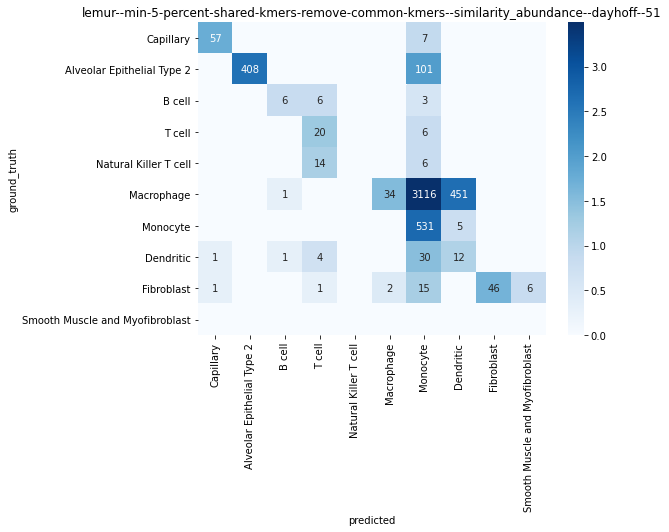

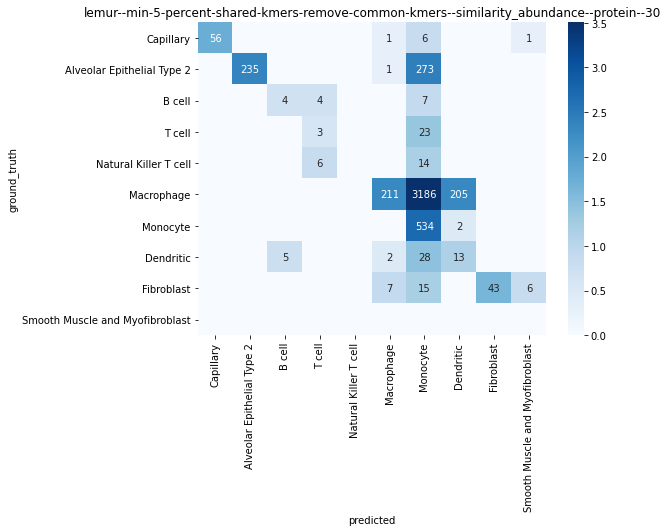

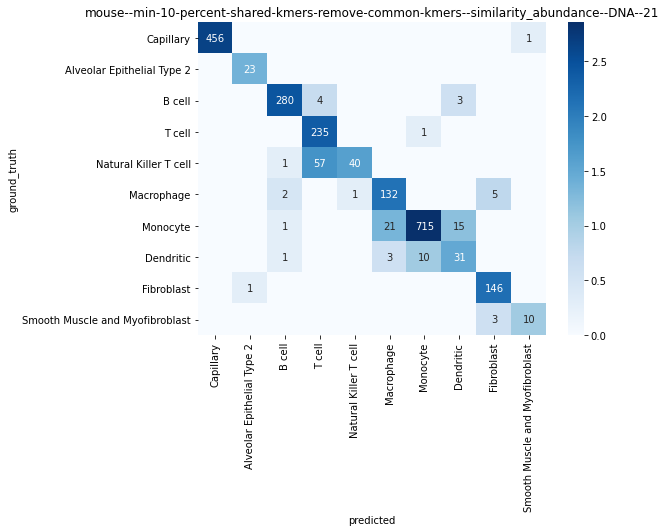

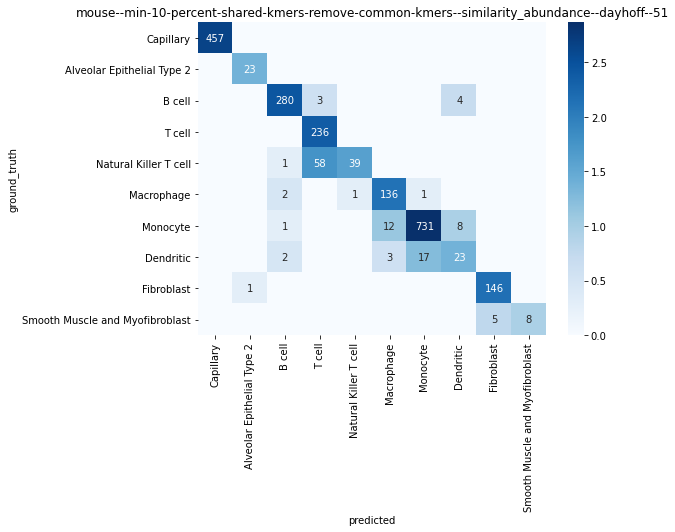

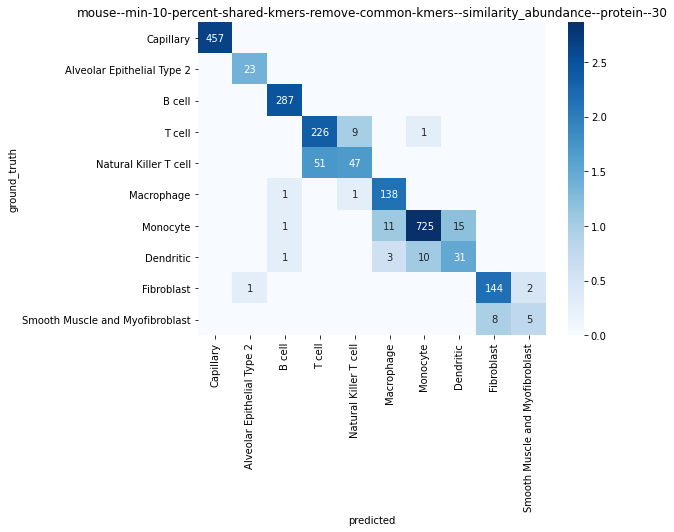

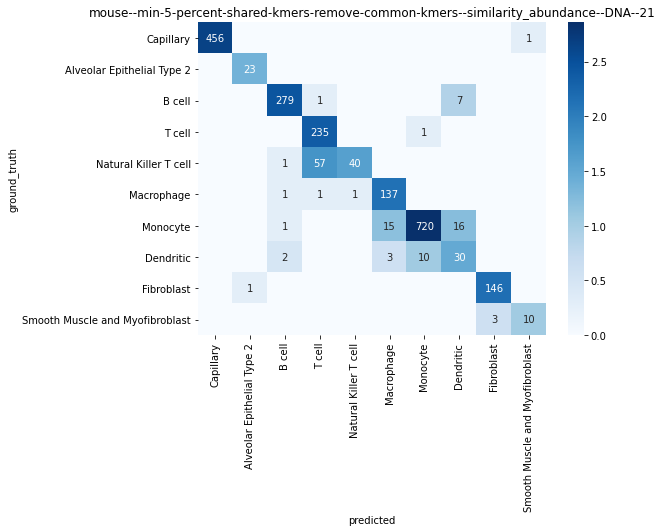

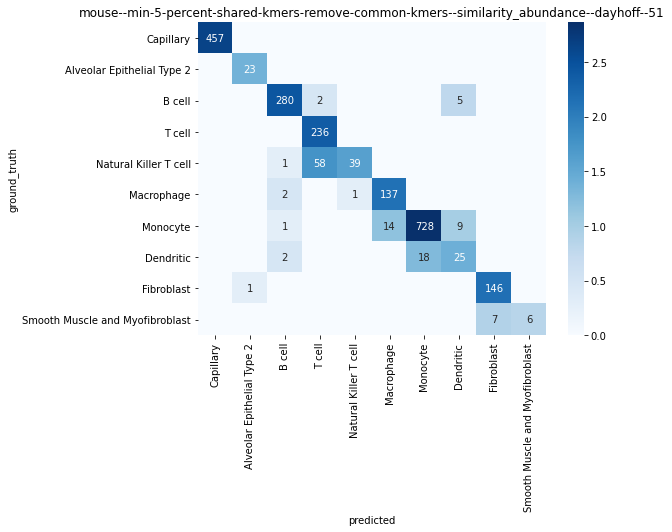

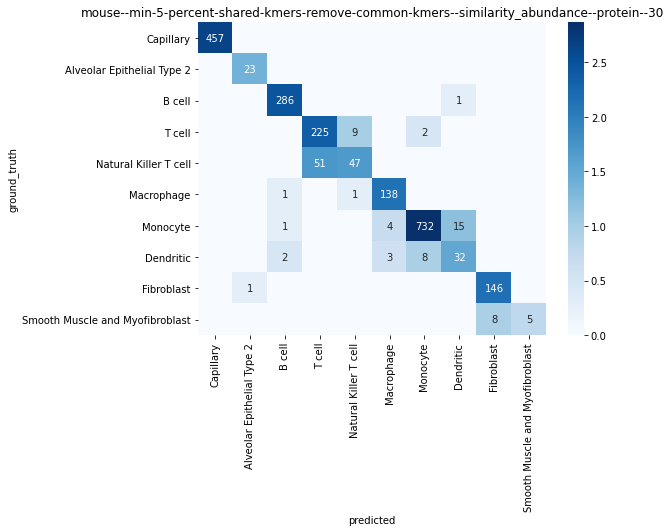

In [34]:
for keys, confusion_df in top_hit_confusion_dfs.items():
#     ksize, alphabet = keys
    fig, ax = plt.subplots(figsize=(9, 7.5))
    
    # Reorder by compartment
#     index = broad_to_compartment.index.intersection(confusion_df.index)
#     renamer = {broad: f'{broad} ({compartment[:3]})' for broad, compartment in broad_to_compartment[index].items()}
#     confusion_df = confusion_df.loc[index, index]
#     confusion_df = confusion_df.rename(columns=renamer, index=renamer)
    
    
    # Annotate only where nonzero
    annot = confusion_df[confusion_df > 0]
    # Replace all NAs (previously 0s) with an empty string
    annot = annot.applymap(lambda x: '' if pd.isnull(x) else str(int(x)))
#     annot = True
    
    sns.heatmap(np.log10(confusion_df + 1), annot=annot, fmt='s', cmap='Blues')
    title = '--'.join(map(str, keys))
    ax.set(title=title)
#     ax.set(title=f"Alphabet: {alphabet}, k-mer size: {ksize}")
    pdf = os.path.join(broad_confusion_matrix_folder, f'{title}.pdf')
    fig.tight_layout()

    fig.savefig(pdf)

# Compartment

## Booststrap and compute score

In [35]:
broad_to_compartment.unique()

array(['endothelial', 'epithelial', 'lymphoid', 'myeloid', 'stromal'],
      dtype=object)

In [36]:
%%time

scoring_groupby = ['comparison', 'database_type', 'alphabet', 'ksize']
ground_truth_celltype_col = 'groundtruth_compartment'
predicted_celltype_col = 'predicted_compartment'


grouped = predicted_cells.groupby(scoring_groupby)

dfs = Parallel(n_jobs=96)(
    delayed(classification_metrics.subsample_and_score)(
        df,
        scoring_groupby=scoring_groupby,
        keys=keys,
        predicted_celltype_col=predicted_celltype_col,
        ground_truth_celltype_col=ground_truth_celltype_col,
        labels=broad_to_compartment.unique(),
    )
    for keys, df in tqdm(grouped, total=len(grouped))
)
compartment_metrics = pd.concat(
    dfs, ignore_index=True
)
describe(compartment_metrics)

100%|██████████| 24/24 [00:00<00:00, 215.07it/s]


(48000, 7)
--- First 5 entries ---


,comparison,database_type,alphabet,ksize,score_value,score_name,iteration
0,bat,min-10-percent-shared-kmers-remove-common-kmers,DNA,21,0.782137,f1_score,0
1,bat,min-10-percent-shared-kmers-remove-common-kmers,DNA,21,0.641860,adjusted_rand_score,0
2,bat,min-10-percent-shared-kmers-remove-common-kmers,DNA,21,0.499329,f1_score,1
3,bat,min-10-percent-shared-kmers-remove-common-kmers,DNA,21,0.720000,adjusted_rand_score,1
4,bat,min-10-percent-shared-kmers-remove-common-kmers,DNA,21,0.516289,f1_score,2


CPU times: user 1.22 s, sys: 130 ms, total: 1.35 s
Wall time: 57.6 s


### Plot compartment metrics

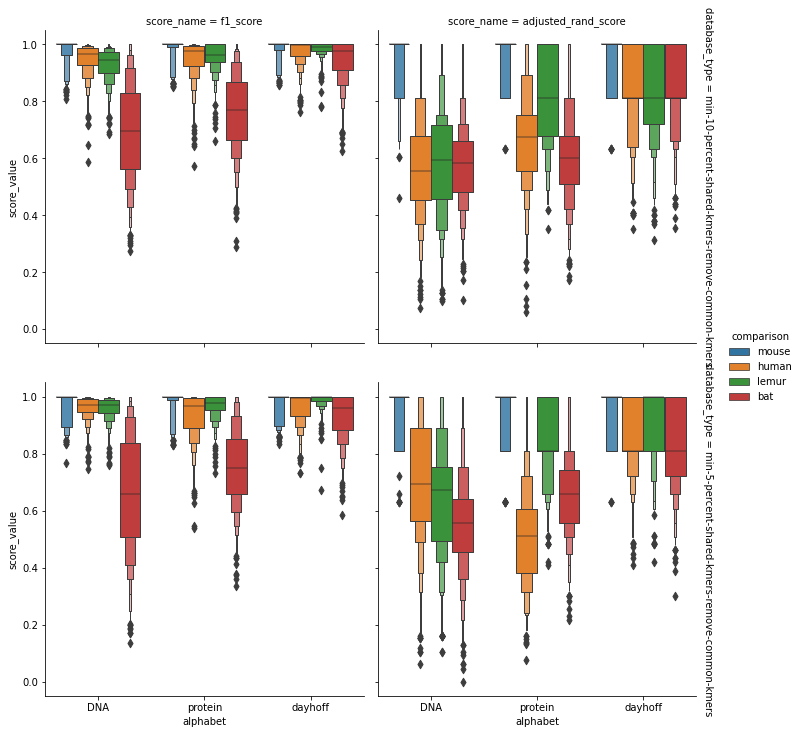

In [61]:
sns.catplot(
    
    data=compartment_metrics,
    x="alphabet",
    y="score_value",
    col="score_name",
    row='database_type',
    hue="comparison",
    kind='boxen',
    hue_order=species_order,
    order=alphabet_order,
    margin_titles=True
)

In [62]:
compartment_metrics.query(
    'alphabet == "dayhoff" and comparison == "human"'
).groupby(["alphabet", "score_name", "database_type", "comparison"]).score_value.mean()

alphabet  score_name           database_type                                    comparison
dayhoff   adjusted_rand_score  min-10-percent-shared-kmers-remove-common-kmers  human         0.837279
                               min-5-percent-shared-kmers-remove-common-kmers   human         0.874091
          f1_score             min-10-percent-shared-kmers-remove-common-kmers  human         0.973754
                               min-5-percent-shared-kmers-remove-common-kmers   human         0.962505
Name: score_value, dtype: float64

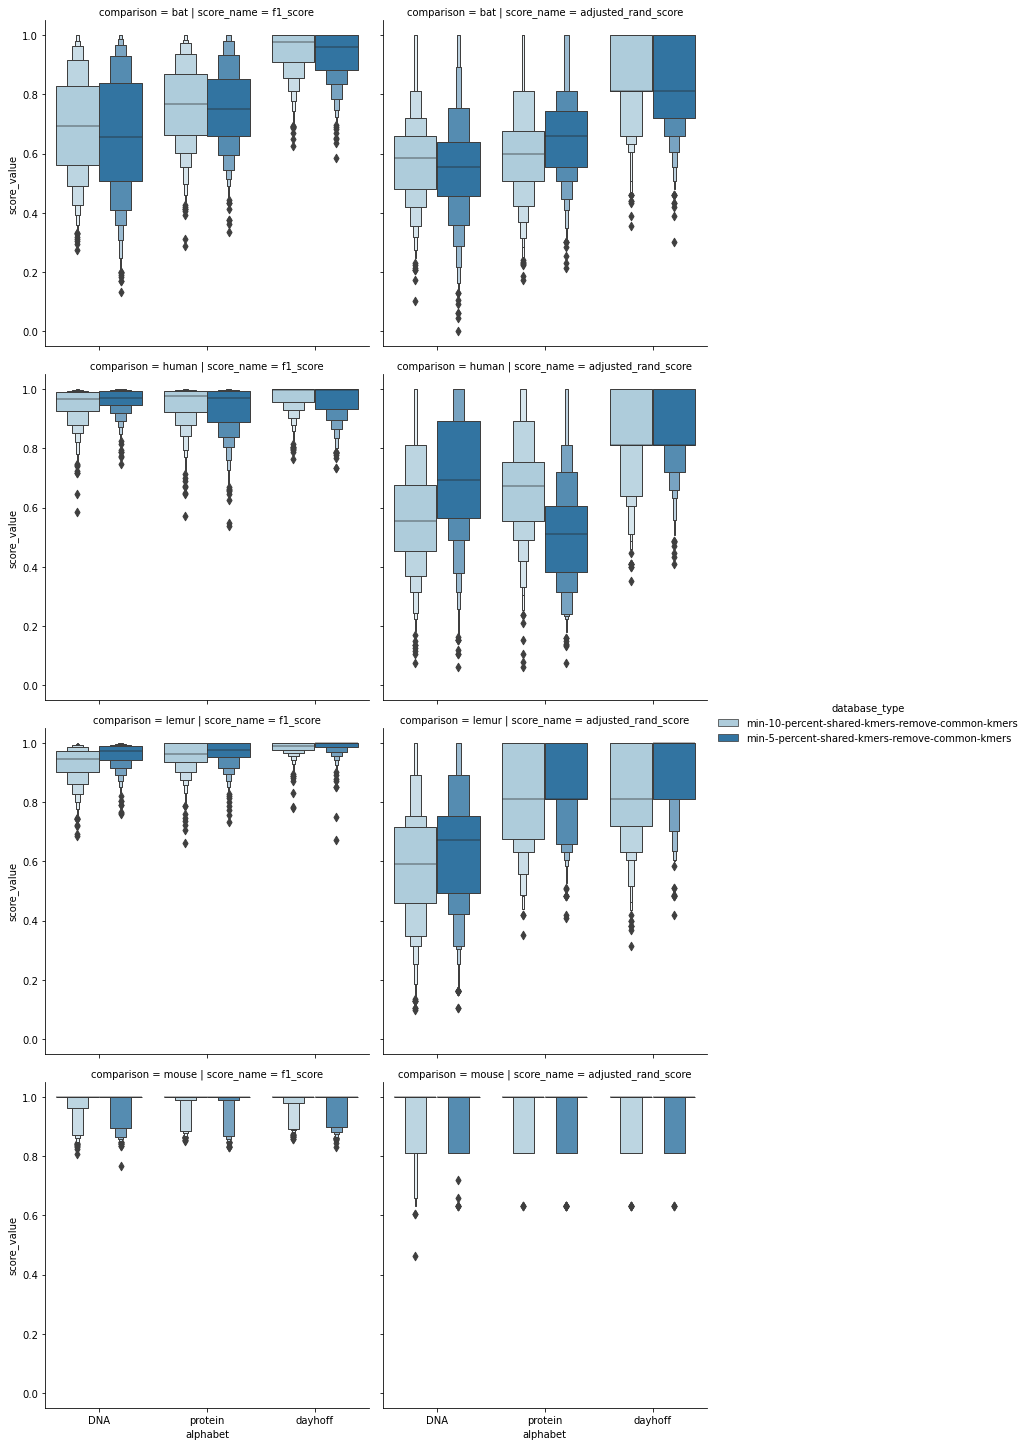

In [63]:
sns.catplot(
    
    data=compartment_metrics,
    x="alphabet",
    y="score_value",
    col="score_name",
    hue='database_type',
    row="comparison",
    kind='boxen',
#     hue_order=hue_order,
    order=alphabet_order,
    palette='Paired'
)

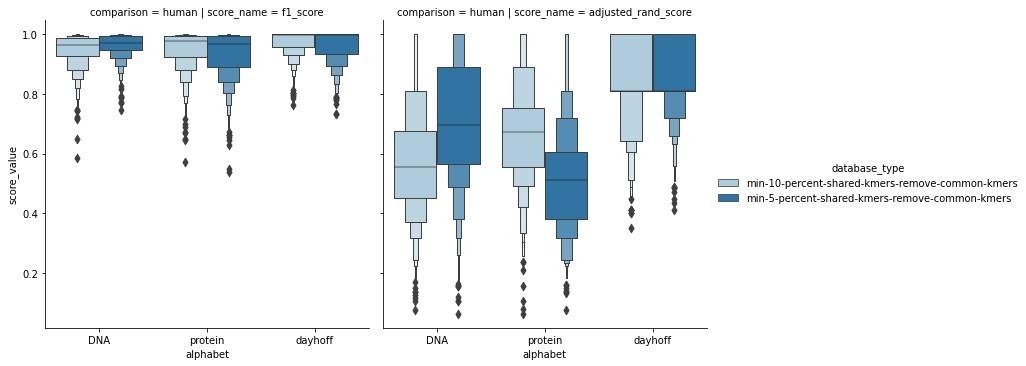

In [64]:
sns.catplot(
    
    data=compartment_metrics.query('comparison == "human"'),
    x="alphabet",
    y="score_value",
    col="score_name",
    hue='database_type',
    row="comparison",
    kind='boxen',
#     hue_order=hue_order,
    order=alphabet_order,
    palette='Paired'
)

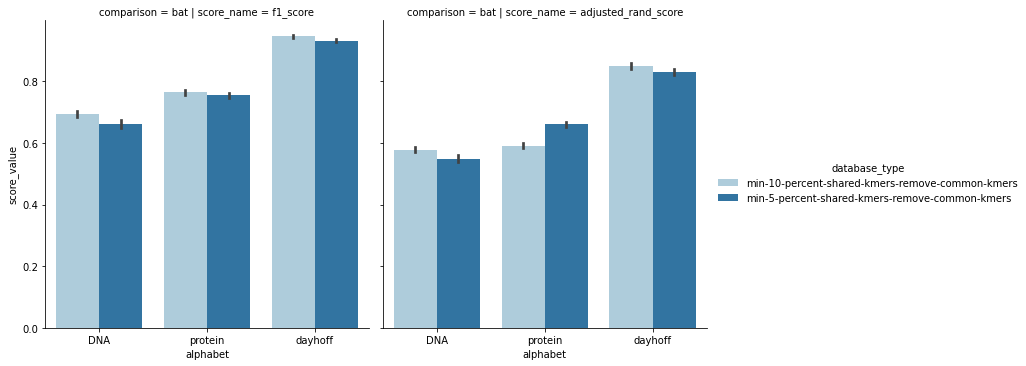

In [67]:
sns.catplot(
    
    data=compartment_metrics.query('comparison == "bat"'),
    x="alphabet",
    y="score_value",
    col="score_name",
    hue='database_type',
    row="comparison",
    kind='bar',
#     hue_order=hue_order,
    order=alphabet_order,
    palette='Paired'
)

### @paper resized, small barplot of F1 and Adjusted Rand scores

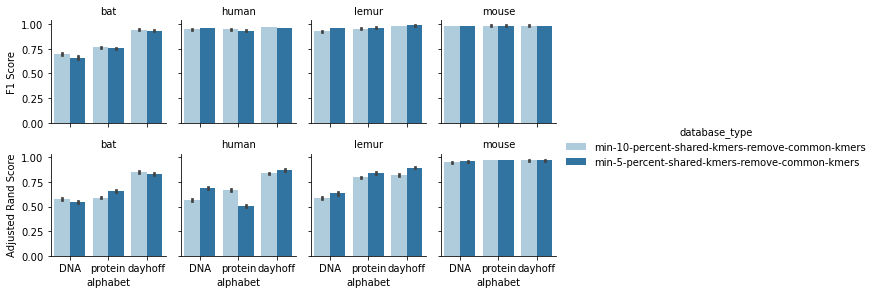

In [66]:
g = sns.catplot(
    
    data=compartment_metrics,
    x="alphabet",
    y="score_value",
    row="score_name",
    hue='database_type',
    col="comparison",
    kind='bar',
#     hue_order=hue_order,
    order=alphabet_order,
    palette='Paired',
    height=2,
#     margin_titles=True
)
g.set_titles('{col_name}')
for ax in g.axes.flat:
    if ax.is_first_col():
        if ax.is_first_row():
            ax.set_ylabel('F1 Score')
        elif ax.is_last_row():
            ax.set_ylabel("Adjusted Rand Score")
        

## Compute Confusion matrices

In [43]:
"""
The F1 score can be interpreted as a weighted average of the precision and recall, 
where an F1 score reaches its best value at 1 and worst score at 0
"""

"""
By definition a confusion matrix is such that is equal to the number of 
observations known to be in group and predicted to be in group
"""

compartment_confusion_dfs = {}

for keys, df in predicted_cells.groupby(scoring_groupby):

    ground_truth = df[ground_truth_celltype_col]
    predicted = df[predicted_celltype_col]
    weight = df["similarity"]
    labels = sorted(list(set(ground_truth) | set(predicted)))

    cm = confusion_matrix(
        ground_truth,
        predicted,
        #         labels=labels,
        #         sample_weight=weight
    )
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    cm_df.index.name = "ground_truth"
    cm_df.columns.name = "predicted"
#     cm_df = cm_df.reindex(index=SHARED_CELLTYPES, columns=SHARED_CELLTYPES)
#     cm_df = cm_df.loc[SHARED_CELLTYPES, SHARED_CELLTYPES]
    compartment_confusion_dfs[keys] = cm_df

### @paper Separately plot confusion matrices to fine tune parameters

In [44]:
# broad_to_compartment = one2one.obs.set_index('broad_group')['compartment_group']
# broad_to_compartment = broad_to_compartment.loc[~broad_to_compartment.index.duplicated()]
# broad_to_compartment.head()

In [45]:
# broad_to_compartment = broad_to_compartment.sort_values()
# broad_to_compartment

In [46]:
compartment_confusion_matrix_folder = os.path.join(
    figure_folder, "confusion_matrices", "compartment_group"
)
! mkdir -p $compartment_confusion_matrix_folder

/home/olga/miniconda3/envs/immune-evolution/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


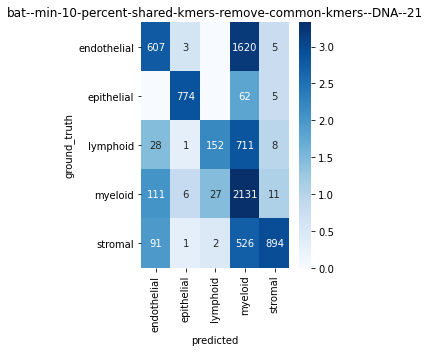

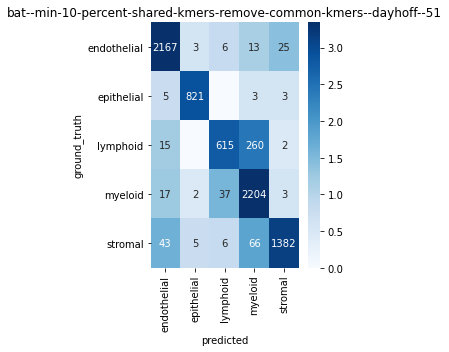

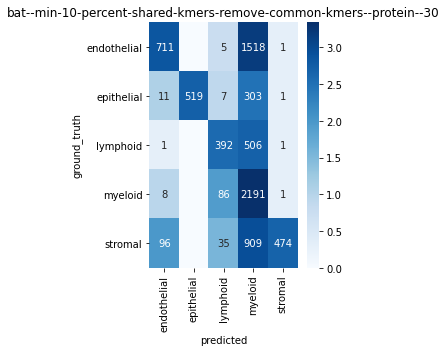

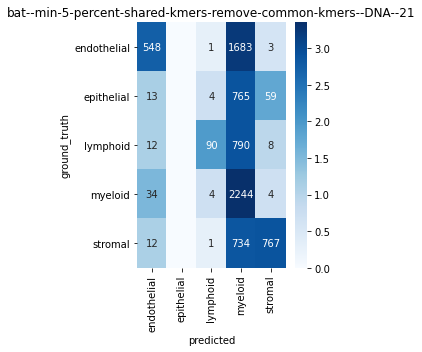

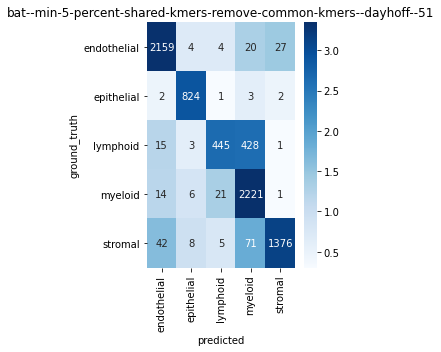

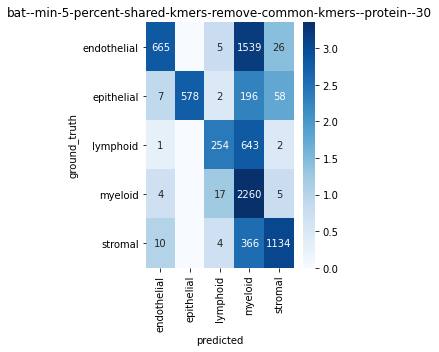

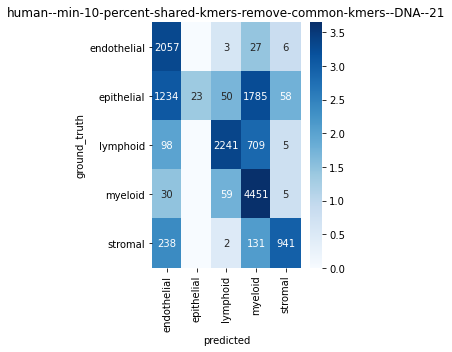

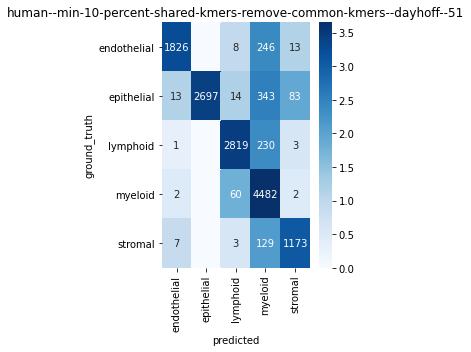

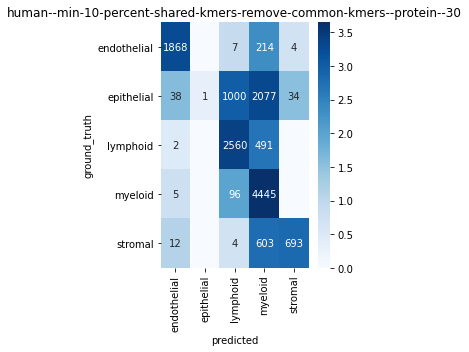

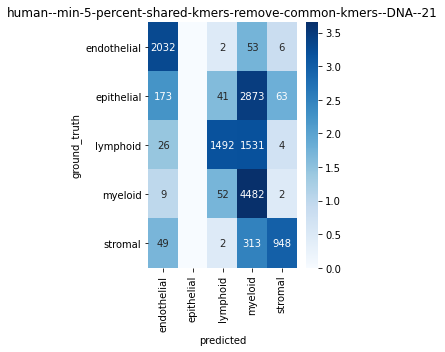

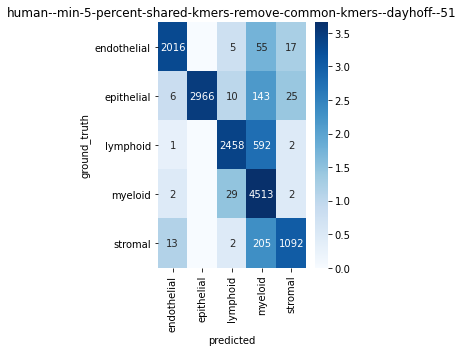

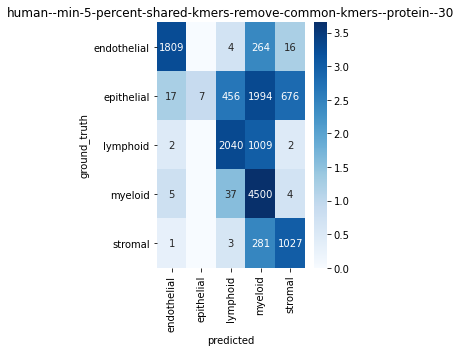

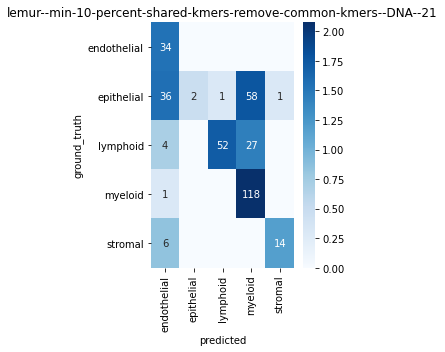

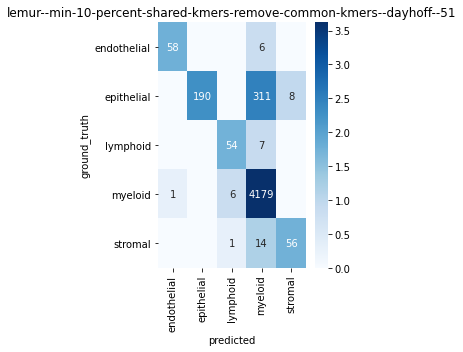

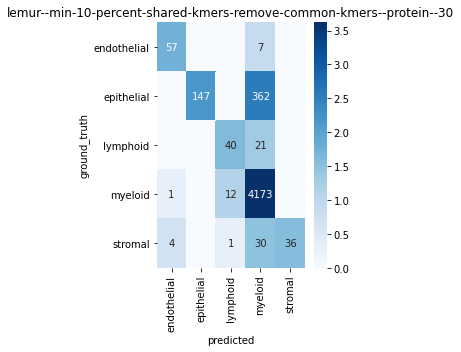

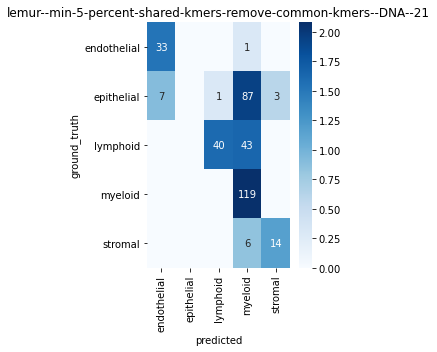

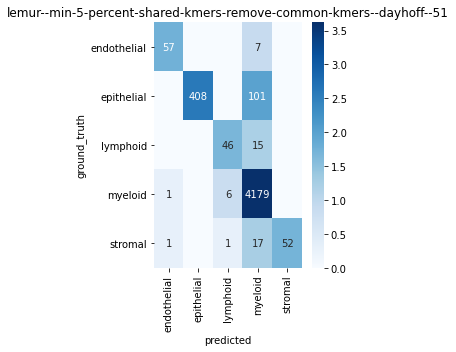

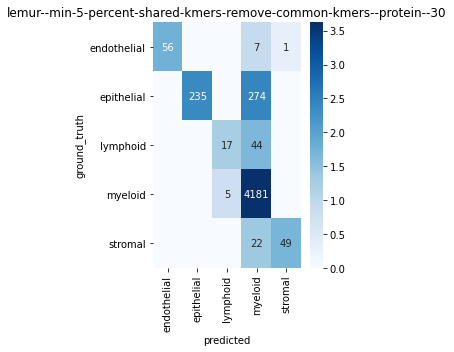

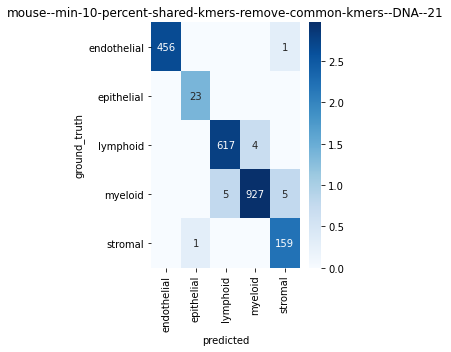

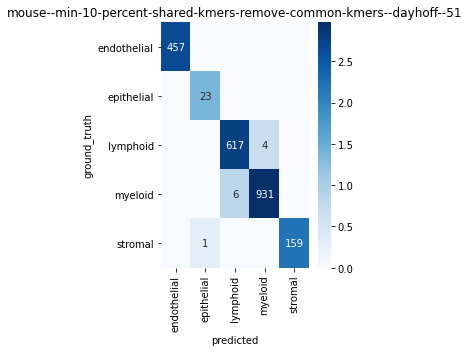

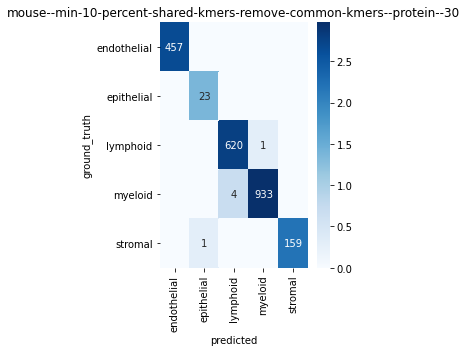

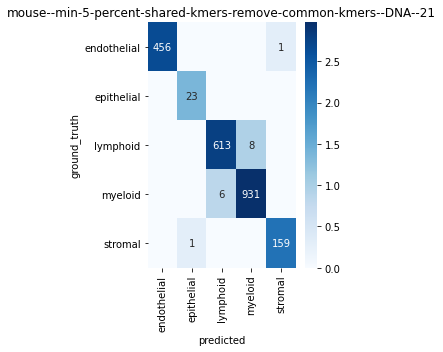

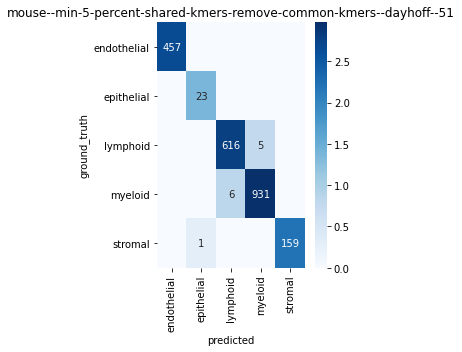

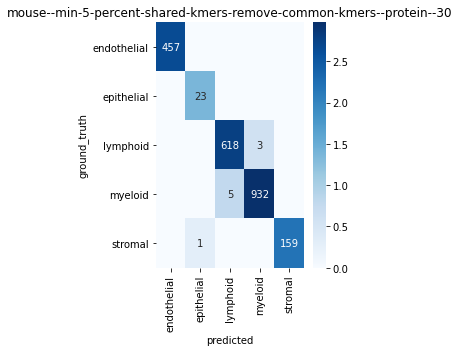

In [47]:
for keys, confusion_df in compartment_confusion_dfs.items():
#     ksize, alphabet = keys
    fig, ax = plt.subplots(figsize=(4, 5))
    
    # Reorder by compartment
#     index = broad_to_compartment.index.intersection(confusion_df.index)
#     renamer = {broad: f'{broad} ({compartment[:3]})' for broad, compartment in broad_to_compartment[index].items()}
#     confusion_df = confusion_df.loc[index, index]
#     confusion_df = confusion_df.rename(columns=renamer, index=renamer)
    
    
    # Annotate only where nonzero
    annot = confusion_df[confusion_df > 0]
    # Replace all NAs (previously 0s) with an empty string
    annot = annot.applymap(lambda x: '' if pd.isnull(x) else str(int(x)))
#     annot = True
    
    sns.heatmap(np.log10(confusion_df + 1), annot=annot, fmt='s', cmap='Blues')
    title = '--'.join(map(str, keys))
    ax.set(title=title)
#     ax.set(title=f"Alphabet: {alphabet}, k-mer size: {ksize}")
    pdf = os.path.join(compartment_confusion_matrix_folder, f'{title}.pdf')
    fig.tight_layout()
    fig.savefig(pdf)

# Concatenate classification metrics

In [48]:
compartment_metrics

,comparison,database_type,alphabet,ksize,score_value,score_name,iteration
0,bat,min-10-percent-shared-kmers-remove-common-kmers,DNA,21,0.782137,f1_score,0
1,bat,min-10-percent-shared-kmers-remove-common-kmers,DNA,21,0.641860,adjusted_rand_score,0
2,bat,min-10-percent-shared-kmers-remove-common-kmers,DNA,21,0.499329,f1_score,1
3,bat,min-10-percent-shared-kmers-remove-common-kmers,DNA,21,0.720000,adjusted_rand_score,1
4,bat,min-10-percent-shared-kmers-remove-common-kmers,DNA,21,0.516289,f1_score,2
...,...,...,...,...,...,...,...
47995,mouse,min-5-percent-shared-kmers-remove-common-kmers,protein,30,1.000000,adjusted_rand_score,997
47996,mouse,min-5-percent-shared-kmers-remove-common-kmers,protein,30,1.000000,f1_score,998
47997,mouse,min-5-percent-shared-kmers-remove-common-kmers,protein,30,1.000000,adjusted_rand_score,998
47998,mouse,min-5-percent-shared-kmers-remove-common-kmers,protein,30,1.000000,f1_score,999


In [49]:
compartment_metrics.groupby(['comparison', 'database_type']).size()

comparison  database_type                                  
bat         min-10-percent-shared-kmers-remove-common-kmers    6000
            min-5-percent-shared-kmers-remove-common-kmers     6000
human       min-10-percent-shared-kmers-remove-common-kmers    6000
            min-5-percent-shared-kmers-remove-common-kmers     6000
lemur       min-10-percent-shared-kmers-remove-common-kmers    6000
            min-5-percent-shared-kmers-remove-common-kmers     6000
mouse       min-10-percent-shared-kmers-remove-common-kmers    6000
            min-5-percent-shared-kmers-remove-common-kmers     6000
dtype: int64

In [50]:
broad_classification_metrics['grouping'] = 'celltype'
compartment_metrics['grouping'] = 'compartment'

In [51]:
broad_classification_metrics.database_type.unique()

array(['min-10-percent-shared-kmers-remove-common-kmers',
       'min-5-percent-shared-kmers-remove-common-kmers'], dtype=object)

In [70]:
concatenated_metrics = pd.concat([broad_classification_metrics, compartment_metrics])
# concatenated_metrics = concatenated_metrics.query('database_type == "min-10-percent-shared-kmers-remove-common-kmers"')

# concatenated_metrics = concatenated_metrics.query('database_type == "remove_common"')
describe(concatenated_metrics)

(96000, 11)
--- First 5 entries ---


,comparison,database_type,search_method,alphabet,ksize,score_value,score_name,iteration,database_method,alpha_ksize,grouping
0,bat,min-10-percent-shared-kmers-remove-common-kmers,similarity_abundance,DNA,21,0.483092,f1_score,0,min-10-percent-shared-kmers-remove-common-kmer...,"DNA, k: 21",celltype
1,bat,min-10-percent-shared-kmers-remove-common-kmers,similarity_abundance,DNA,21,0.424779,adjusted_rand_score,0,min-10-percent-shared-kmers-remove-common-kmer...,"DNA, k: 21",celltype
2,bat,min-10-percent-shared-kmers-remove-common-kmers,similarity_abundance,DNA,21,0.551784,f1_score,1,min-10-percent-shared-kmers-remove-common-kmer...,"DNA, k: 21",celltype
3,bat,min-10-percent-shared-kmers-remove-common-kmers,similarity_abundance,DNA,21,0.408276,adjusted_rand_score,1,min-10-percent-shared-kmers-remove-common-kmer...,"DNA, k: 21",celltype
4,bat,min-10-percent-shared-kmers-remove-common-kmers,similarity_abundance,DNA,21,0.597917,f1_score,2,min-10-percent-shared-kmers-remove-common-kmer...,"DNA, k: 21",celltype


In [71]:
concatenated_metrics_folder = os.path.join(
    figure_folder, "concatenated_metrics"
)
! mkdir -p $concatenated_metrics_folder

## Barplots

In [72]:
species_order

['mouse', 'human', 'lemur', 'bat']

In [55]:
species_order = ['mouse', 'human', 'lemur', 'bat']

--- min-10-percent-shared-kmers-remove-common-kmers ---
--- min-5-percent-shared-kmers-remove-common-kmers ---


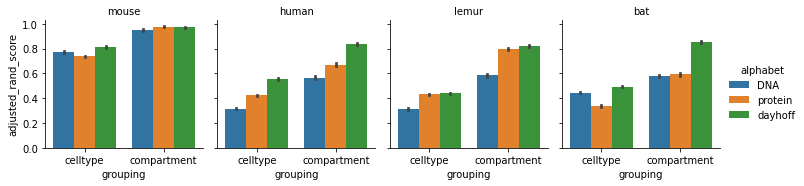

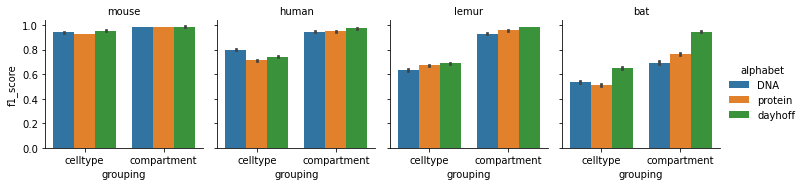

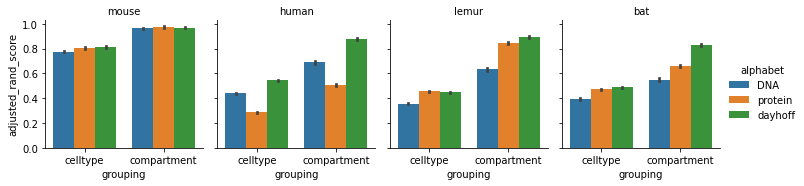

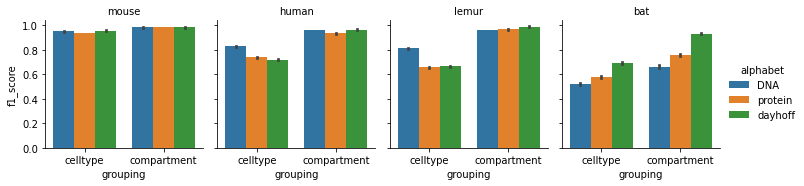

In [73]:
for database_type, database_df in concatenated_metrics.groupby('database_type'):
    print(f'--- {database_type} ---')

    for score_name, df in database_df.groupby('score_name'):
        g = sns.catplot(
            data=df,
            hue="alphabet",
            x="grouping",
            y="score_value",
            col="comparison",
    #         row="score_name",
            kind="bar",
            height=2.5,
            hue_order=alphabet_order,
            col_order=species_order,
            palette="tab10",
        )
        g.set_titles("{col_name}")
        g.set_ylabels(score_name)
        pdf = os.path.join(concatenated_metrics_folder, f"barplot_metrics_per_species__hue-alphabet__{database_type}__{score_name}.pdf")
        g.savefig(pdf)

--- min-10-percent-shared-kmers-remove-common-kmers ---
--- min-5-percent-shared-kmers-remove-common-kmers ---


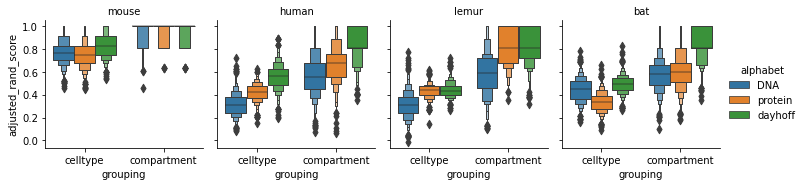

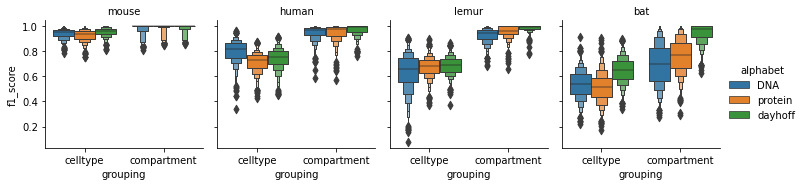

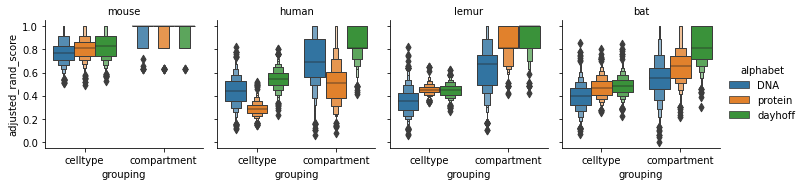

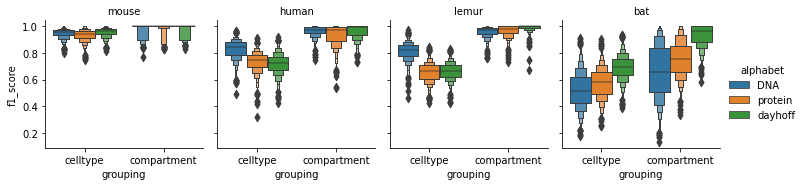

In [77]:
for database_type, database_df in concatenated_metrics.groupby('database_type'):
    print(f'--- {database_type} ---')

    for score_name, df in database_df.groupby('score_name'):
        g = sns.catplot(
            data=df,
            hue="alphabet",
            x="grouping",
            y="score_value",
            col="comparison",
    #         row="score_name",
            kind="boxen",
            height=2.5,
            hue_order=alphabet_order,
            col_order=species_order,
            palette="tab10",
        )
        g.set_titles("{col_name}")
        g.set_ylabels(score_name)
        pdf = os.path.join(concatenated_metrics_folder, f"boxenplot_metrics_per_species__hue-alphabet__{database_type}__{score_name}.pdf")
        g.savefig(pdf)

### @paper - barplot of compartment, celltype metrics per alphabet

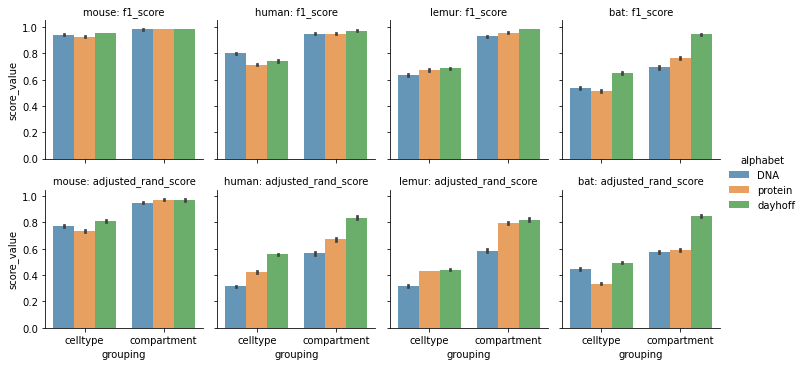

In [58]:
g = sns.catplot(
    data=concatenated_metrics,
    hue="alphabet",
    x="grouping",
    y="score_value",
    col="comparison",
    row="score_name",
    kind="bar",
    height=2.5,
    order=["celltype", "compartment"],
    hue_order=alphabet_order,
    col_order=species_order,
    palette="tab10",
    alpha=0.75,
)
# g.map(sns.stripplot, "grouping", "score_value", dodge=True, zorder=-1, alpha=0.5)
g.set_titles("{col_name}: {row_name}")

## Transparent axes background
# ylim from stripplot
g.set(facecolor=(0.0, 0.0, 0.0, 0.0), ylim=(0, 1.0506825938566553))
pdf = os.path.join(
    concatenated_metrics_folder,
    "barplot_metrics_per_species__hue-alphabet__stripplot.pdf",
)
g.savefig(pdf, transparent=True)

### @paper - stripplot of compartment, celltype metrics per alphabet

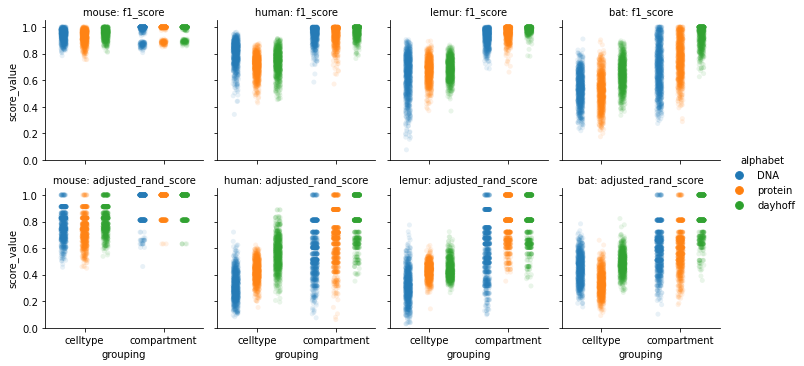

In [59]:
g = sns.catplot(
    data=concatenated_metrics,
    hue="alphabet",
    x="grouping",
    y="score_value",
    col="comparison",
    row="score_name",
    kind="strip",
    height=2.5,
    hue_order=alphabet_order,
    col_order=species_order,
    palette="tab10",
    alpha=0.1,
    dodge=True,
)
# g._colors = sns.palettes._ColorPalette(
#     [
#         (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
#         (1.0, 0.4980392156862745, 0.054901960784313725),
#         (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
#     ]
# )
# g._hue_var = "alphabet"
# g.hue_names = alphabet_order
# g.map(sns.barplot, "grouping", "score_value", zorder=-1, alpha=0.5)


## Transparent axes background
# ylim from stripplot and barplot
g.set(facecolor=(0.0, 0.0, 0.0, 0.0), ylim=(0, 1.0506825938566553))

g.set_titles("{col_name}: {row_name}")
pdf = os.path.join(
    concatenated_metrics_folder,
    "stripplot_metrics_per_species__hue-alphabet.pdf",
)
g.savefig(pdf, transparent=True)

In [60]:
g.hue_kws

{}